<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h1>Should This Loan be Approved or Denied ?</h1>

My attempt at creating an XGBoost data model to predict whether a loan can be approved or denied.  Some notes are given to make sense of it :).
    
Any comments are welcome.
</div>

**Dataset Source**

https://www.kaggle.com/mirbektoktogaraev/should-this-loan-be-approved-or-denied

In [1]:
filepath = "../input/should-this-loan-be-approved-or-denied/"
savepath = "./"

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
%matplotlib inline

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
<h3>1. Load File</h3></div>

In [3]:
sba = pd.read_csv(filepath + 'SBAnational.csv',low_memory=False)
sba.head(2)

LoanNr_ChkDgt                         Name        City State    Zip  \
0     1000014003               ABC HOBBYCRAFT  EVANSVILLE    IN  47711   
1     1000024006  LANDMARK BAR & GRILLE (THE)   NEW PARIS    IN  46526   

               Bank BankState   NAICS ApprovalDate ApprovalFY  ...  RevLineCr  \
0  FIFTH THIRD BANK        OH  451120    28-Feb-97       1997  ...          N   
1   1ST SOURCE BANK        IN  722410    28-Feb-97       1997  ...          N   

   LowDoc  ChgOffDate  DisbursementDate  DisbursementGross  BalanceGross  \
0       Y         NaN         28-Feb-99        $60,000.00         $0.00    
1       Y         NaN         31-May-97        $40,000.00         $0.00    

   MIS_Status ChgOffPrinGr       GrAppv     SBA_Appv  
0       P I F       $0.00   $60,000.00   $48,000.00   
1       P I F       $0.00   $40,000.00   $32,000.00   

[2 rows x 27 columns]

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Load file with some conversion</b><br>
    After reviewing the dataset at a glance, decided to reload with some conversions
    </div>

In [4]:
def fixvals(val):
    retval = val.replace('$','')
    retval = retval.replace(',','')
    return retval

sba = pd.read_csv(filepath + 'SBAnational.csv',\
                 converters = {'DisbursementGross':fixvals,'SBA_Appv':fixvals,\
                              'GrAppv':fixvals, 'ChgOffPrinGr':fixvals}, \
                              parse_dates=['DisbursementDate'], low_memory=False)
print("Shape of SBA : ", sba.shape)
sba[['DisbursementGross','SBA_Appv','GrAppv','ChgOffPrinGr','DisbursementDate']].head(2)

Shape of SBA :  (899164, 27)


DisbursementGross   SBA_Appv     GrAppv ChgOffPrinGr DisbursementDate
0         60000.00   48000.00   60000.00         0.00        1999-02-28
1         40000.00   32000.00   40000.00         0.00        1997-05-31

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 20px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>2. Data Preparation</h2>
    </div>

In [5]:
print(sba.columns)
print()
print(sba.info())

Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
       'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   LoanNr_ChkDgt      899164 non-null  int64         
 1   Name               899150 non-null  object        
 2   City               899134 non-null  object        
 3   State              899150 non-null  object        
 4   Zip                899164 non-null  int64         
 5   Bank               897605 non-null  object        
 6   BankState          897598 non-null

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>2.1 Convert dtype</h2>
    </div>

In [6]:
sba = sba.astype({'DisbursementGross':np.float64,'SBA_Appv':np.float64,\
                              'GrAppv':np.float64, 'ChgOffPrinGr':np.float64, 'NAICS':np.str_})

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>2.2 Drop rows or columns if needed</h2>
    </div>

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Check for na's in all columns</b></div>

['Name', 'City', 'State', 'Bank', 'BankState', 'NewExist', 'RevLineCr', 'LowDoc', 'ChgOffDate', 'DisbursementDate', 'MIS_Status']


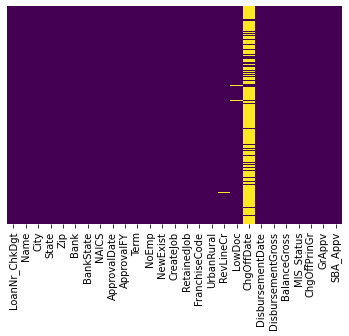

In [7]:
def check_cols_with_nulls(df):
    cols_with_missing = [col for col in df.columns if df[col].isnull().any()]
    if len(cols_with_missing) == 0:
        print("No Missing Values")
    else:
        print(cols_with_missing)
    
    sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

check_cols_with_nulls(sba)

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Column Drop 1 - drop columns deemed not needed</b>
    </div>

In [8]:
# Save 1
sba.to_csv(savepath + "sba_save1.csv",index=False)

In [9]:
cols_to_drop = ['LoanNr_ChkDgt', 'Zip', 'Bank', 'BankState', 'ApprovalDate', 'ApprovalFY', \
                'ChgOffDate', 'BalanceGross']

sba.drop(columns=cols_to_drop, inplace=True)

In [10]:
sba.head(2)

Name        City State   NAICS  Term  NoEmp  \
0               ABC HOBBYCRAFT  EVANSVILLE    IN  451120    84      4   
1  LANDMARK BAR & GRILLE (THE)   NEW PARIS    IN  722410    60      2   

   NewExist  CreateJob  RetainedJob  FranchiseCode  UrbanRural RevLineCr  \
0       2.0          0            0              1           0         N   
1       2.0          0            0              1           0         N   

  LowDoc DisbursementDate  DisbursementGross MIS_Status  ChgOffPrinGr  \
0      Y       1999-02-28            60000.0      P I F           0.0   
1      Y       1997-05-31            40000.0      P I F           0.0   

    GrAppv  SBA_Appv  
0  60000.0   48000.0  
1  40000.0   32000.0

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>DisbursementDate</b>
    </div>

In [11]:
x = sba[sba['DisbursementDate'].isna()]
print(x.shape)

(2368, 19)


In [12]:
# Not many nulls for DisbursementDate vis-a-vis to the dataset length, so drop rows with null
sba.dropna(subset=['DisbursementDate'], how='all', inplace=True)
x = sba[sba['DisbursementDate'].isna()]
print(x.shape)

(0, 19)


<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>RevLineCr</b></div>

In [13]:
len(sba[(sba['RevLineCr'] != 'Y') & (sba['RevLineCr'] != 'N')])

277327

In [14]:
# too many unknowns, drop 'RevlineCr'
sba.drop(columns=['RevLineCr'],inplace=True)
'RevLineCR' in sba.columns

False

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>LowDoc</b></div>

In [15]:
sba['LowDoc'].isna().sum()

2550

In [16]:
len(sba[(sba['LowDoc'] != 'Y') & (sba['LowDoc'] != 'N')])

5965

<AxesSubplot:xlabel='LowDoc', ylabel='count'>

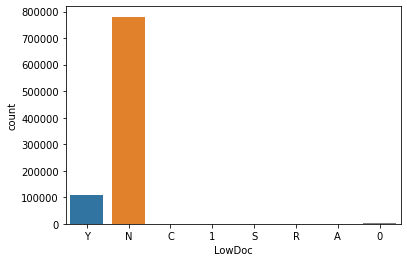

In [17]:
sns.countplot(x='LowDoc',data=sba)

* **LowDoc seems to have a bearing**

In [18]:
# 5965 records that are not 'Y' or 'N', we can drop these rows
sba = sba[(sba['LowDoc'] == 'Y') | (sba['LowDoc'] == 'N')]
len(sba[(sba['LowDoc'] != 'Y') & (sba['LowDoc'] != 'N')])

0

In [19]:
len(sba[(sba['LowDoc'] == 'Y') | (sba['LowDoc'] == 'N')])

890831

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>NewExist</b>

In [20]:
len(sba[(sba['NewExist'] != 1) & (sba['NewExist'] != 2)])

1154

<AxesSubplot:xlabel='NewExist', ylabel='count'>

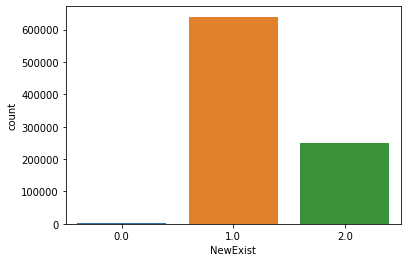

In [21]:
sns.countplot(x='NewExist',data=sba)

In [22]:
# 1154 records that are not 1 or 2, we can drop these rows as NewExist seems to have a bearing
sba = sba[(sba['NewExist'] == 1) | (sba['NewExist'] == 2)]
len(sba[(sba['NewExist'] != 1) & (sba['NewExist'] != 2)])

0

In [23]:
len(sba[(sba['NewExist'] == 1) | (sba['NewExist'] == 2)])

889677

In [24]:
# ideally, convert dtype to int32
sba = sba.astype({'NewExist':np.int32})

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>CreateJob</b></div>

In [25]:
len(sba[sba['CreateJob'].isna() == True])

0

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>RetainedJob</b></div>

In [26]:
len(sba[sba['RetainedJob'].isna() == True])

0

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>FranchiseCode</b></div>

In [27]:
len(sba[sba['FranchiseCode'].isna()])

0

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>UrbanRural</b></div>

In [28]:
print(len(sba[sba['UrbanRural'].isna()]))
sba['UrbanRural'].unique()

0


array([0, 1, 2])

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>NoEmp</b></div>

In [29]:
len(sba[sba['NoEmp'].isna()])

0

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Term</b></div>

In [30]:
print(len(sba[sba['Term'].isna()]))
print(len(sba[sba['Term']==0]))
print(len(sba[sba['Term']<0]))

0
805
0


<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>City</b></div>

In [31]:
len(sba[sba['City'].isna()])

30

In [32]:
# drop na in City column
sba = sba[sba['City'].notna()]
len(sba[sba['City'].isna()])

0

In [33]:
sba.head(2)

Name        City State   NAICS  Term  NoEmp  \
0               ABC HOBBYCRAFT  EVANSVILLE    IN  451120    84      4   
1  LANDMARK BAR & GRILLE (THE)   NEW PARIS    IN  722410    60      2   

   NewExist  CreateJob  RetainedJob  FranchiseCode  UrbanRural LowDoc  \
0         2          0            0              1           0      Y   
1         2          0            0              1           0      Y   

  DisbursementDate  DisbursementGross MIS_Status  ChgOffPrinGr   GrAppv  \
0       1999-02-28            60000.0      P I F           0.0  60000.0   
1       1997-05-31            40000.0      P I F           0.0  40000.0   

   SBA_Appv  
0   48000.0  
1   32000.0

In [34]:
# Trim leading and trailing spaces
sba['City'] = sba['City'].str.strip()

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>State</b></div>

In [35]:
len(sba[sba['State'].isna()])

12

In [36]:
# drop na in State column
sba = sba[sba['State'].notna()]
len(sba[sba['State'].isna()])

0

<div style="font-family: Trebuchet MS;background-color:Chocolate;color:AliceBlue;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>MIS_Status<b> - this is the **target** variable</div>

In [37]:
len(sba.loc[sba['MIS_Status'].isna()])

1795

In [38]:
# drop na in 'MIS_Status' column
sba = sba[sba['MIS_Status'].notna()]
len(sba[sba['MIS_Status'].isna()])

0

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>NAICS</b></div>

In [39]:
len(sba[sba['NAICS'].isna()])

0

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Name</b> - keeping this feature temporarily, in case it is needed
    </div>

In [40]:
len(sba[sba['Name'].isna()])

14

In [41]:
# drop rows with na in column 'Name'
sba.dropna(subset=['Name'], how='all', inplace=True)
len(sba[sba['Name'].isna()])

0

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Check for na's in all columns</b></div>

No Missing Values


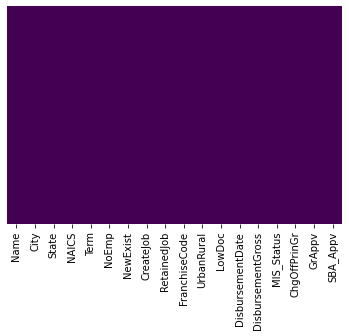

In [42]:
check_cols_with_nulls(sba)  # this function was defined earlier above

In [43]:
# Save 2
sba.to_csv(savepath + "sba_save2.csv",index=False)

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>2.3 Create New Features</h2>
    </div>

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Industry</b> - The industry sector is the 1st 2 digits of NAICS
    </div>

In [44]:
sba['Industry'] = sba['NAICS'].str[0:2]
sba = sba.astype({'Industry':np.int32})

In [45]:
sba['Industry'].head(2)

0    45
1    72
Name: Industry, dtype: int32

In [46]:
sba['Industry'].unique()
# There is an invalid industry shown which is '0', caused by blank NAICS

array([45, 72, 62,  0, 33, 81, 23, 44, 42, 61, 53, 54, 31, 51, 71, 52, 21,
       32, 56, 48, 11, 92, 22, 49, 55], dtype=int32)

In [47]:
len(sba[sba['Industry'] == 0])
# This is a bummer, as industry sector has a big effect on a business, speaking as a business 
# domain expert.  Do we drop those with NAICS = 0 ?

200089

In [48]:
# At this stage, we leave it as is and treat it as unknown industry.  We can now drop NAICS

sba.drop(columns=['NAICS'], inplace=True)
sba.head(2)

Name        City State  Term  NoEmp  NewExist  \
0               ABC HOBBYCRAFT  EVANSVILLE    IN    84      4         2   
1  LANDMARK BAR & GRILLE (THE)   NEW PARIS    IN    60      2         2   

   CreateJob  RetainedJob  FranchiseCode  UrbanRural LowDoc DisbursementDate  \
0          0            0              1           0      Y       1999-02-28   
1          0            0              1           0      Y       1997-05-31   

   DisbursementGross MIS_Status  ChgOffPrinGr   GrAppv  SBA_Appv  Industry  
0            60000.0      P I F           0.0  60000.0   48000.0        45  
1            40000.0      P I F           0.0  40000.0   32000.0        72

In [49]:
# Check if we can impute from the name.  For example, a bar (or similar) business
sba[(sba['Name'].str.contains('bar',case=False)) & (sba['Industry'] == 0)]\
    [['Name','Industry']].head(10)

Name  Industry
692            DICKEY'S BARBECUE PIT         0
892      MID-STATE REBAR FABRICATORS         0
2763      MCDUFFY'S SPORTS BAR, INC.         0
3488  PETRUCCI'S DAIRY BARN OF MARLT         0
3941       SEOUL BARBECUE RESTAURANT         0
4022   STEAMERS RAW BAR & SEA GRILLE         0
4748             QUALITY INN BARSTOW         0
7856     THE ISLANDS RAW BAR & GRILL         0
7895  SANTA BARBARA PERIPHERALS INC.         0
8047   M'S PLACE SMOKEHOUSE BARBEQUE         0

**It's not feasible to impute missing Industry codes efficiently, so we abandon the idea.**

In [50]:
# We can also drop 'Name' now
sba.drop(columns='Name',inplace=True)

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Recession</b><br>
We want to account for variation due to the Great Recession (December 2007 to June 2009). Should we separate the datasets into different time periods ? Before, During, and After ?  Let's check how large the sets are later.  In the meantime, we create a new feature, Recession, with 1 for 'Y' and 0 for 'N' depending on the DisbursementDate. 
<br><br>
</div>

In [ ]:
# Convert "DisbursementDate" to datetime

# sba['DisbursementDate'] = pd.to_datetime(sba['DisbursementDate'], format='%d-%b-%y')

# sba.head(2)

In [51]:
# Create new column based on condition
sba['Recession'] = np.where((sba['DisbursementDate'] >= '2007-09-01')\
                     & (sba['DisbursementDate'] <= '2009-06-30'), 1, 0)

In [52]:
print(f'Total - {len(sba)}')
y = len(sba[sba['Recession'] == 1])
n = len(sba[sba['Recession'] == 0])
print(f'Yes - {y}')
print(f'No - {n}')
print(f'Yes and No - {y+n}')


Total - 887826
Yes - 65647
No - 822179
Yes and No - 887826


<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Real Estate</b><br>
Loans backed by real estate will have terms 20 years or greater (≥240 months) and are the only loans granted for such a long term, whereas loans not backed by real estate will have terms less than 20 years ( < 240 months).<br><br>
1 - Backed By Real Estate<br>
0 - Not Backed By Real Estate<br><br>

In [53]:
# Create new column based on condition
sba['RealEstate'] = np.where(sba['Term'] >= 240, 1, 0)

In [54]:
print(f'Total - {len(sba)}')
y = len(sba[sba['RealEstate'] == 1])
n = len(sba[sba['RealEstate'] == 0])
print(f'Yes - {y}')
print(f'No - {n}')
print(f'Yes and No - {y+n}')

Total - 887826
Yes - 150700
No - 737126
Yes and No - 887826


<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>SBA_Portion</b><br>
The portion which is the percentage of the loan that is guaranteed by SBA. This is derived by calculating the ratio of the amount of the loan SBA guarantees and the gross amount approved by the bank (SBA_Appv/GrAppv) * 100.<br><br></div>

In [55]:
sba['SBA_Portion']=(sba['SBA_Appv']/sba['GrAppv']) * 100
sba.head(2)

City State  Term  NoEmp  NewExist  CreateJob  RetainedJob  \
0  EVANSVILLE    IN    84      4         2          0            0   
1   NEW PARIS    IN    60      2         2          0            0   

   FranchiseCode  UrbanRural LowDoc DisbursementDate  DisbursementGross  \
0              1           0      Y       1999-02-28            60000.0   
1              1           0      Y       1997-05-31            40000.0   

  MIS_Status  ChgOffPrinGr   GrAppv  SBA_Appv  Industry  Recession  \
0      P I F           0.0  60000.0   48000.0        45          0   
1      P I F           0.0  40000.0   32000.0        72          0   

   RealEstate  SBA_Portion  
0           0         80.0  
1           0         80.0

**CityState**

In [56]:
sba["CityState"] = sba["City"] + "_" + sba["State"]
sba[["CityState", "City", "State"]].head()

CityState          City State
0    EVANSVILLE_IN    EVANSVILLE    IN
1     NEW PARIS_IN     NEW PARIS    IN
2   BLOOMINGTON_IN   BLOOMINGTON    IN
3  BROKEN ARROW_OK  BROKEN ARROW    OK
4       ORLANDO_FL       ORLANDO    FL

In [57]:
sba.head(2)

City State  Term  NoEmp  NewExist  CreateJob  RetainedJob  \
0  EVANSVILLE    IN    84      4         2          0            0   
1   NEW PARIS    IN    60      2         2          0            0   

   FranchiseCode  UrbanRural LowDoc  ... DisbursementGross  MIS_Status  \
0              1           0      Y  ...           60000.0       P I F   
1              1           0      Y  ...           40000.0       P I F   

  ChgOffPrinGr   GrAppv  SBA_Appv  Industry  Recession  RealEstate  \
0          0.0  60000.0   48000.0        45          0           0   
1          0.0  40000.0   32000.0        72          0           0   

   SBA_Portion      CityState  
0         80.0  EVANSVILLE_IN  
1         80.0   NEW PARIS_IN  

[2 rows x 21 columns]

In [58]:
# Save 3
sba.to_csv(savepath + 'sba_save3.csv',index=False)

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>2.4 Encode Categorical Features</h2>
    </div>

In [59]:
sba.select_dtypes(["object"]).nunique()

City          32346
State            51
LowDoc            2
MIS_Status        2
CityState     44196
dtype: int64

<div style="font-family: Trebuchet MS;background-color:Chocolate;color:AliceBlue;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>MIS_Status</b><br>
    This will be the <b>target</b> variable</div>

P I F     732244
CHGOFF    155582
Name: MIS_Status, dtype: int64


<AxesSubplot:xlabel='MIS_Status', ylabel='count'>

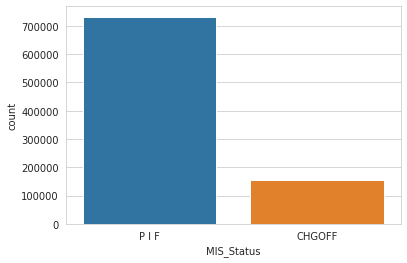

In [60]:
sns.set_style('whitegrid')
# Target variable is MIS Status, a categorical variable

print(sba['MIS_Status'].value_counts())
sns.countplot(x='MIS_Status',data=sba)

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    This shows a skewed distribution, where this bias in the target can influence many machine learning algorithms, leading some to ignore the minority class entirely, in this case, CHGOFF.  Before oversampling the data, will try as is.<br><br></div>

In [61]:
# Update column based on condition
sba['MIS_Status'] = np.where((sba['MIS_Status'] == 'P I F'), 1, 0)

In [62]:
print(sba['MIS_Status'].dtype)
sba.head(2)[['City','MIS_Status']]

int64


City  MIS_Status
0  EVANSVILLE           1
1   NEW PARIS           1

In [63]:
# ideally, convert dtype to int32
sba = sba.astype({'MIS_Status':np.int32})
sba['MIS_Status'].dtype

dtype('int32')

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>LowDoc</b><br>
'Y' = 1<br>
'N' = 0

In [64]:
# Update column based on condition
sba['LowDoc'] = np.where((sba['LowDoc'] == 'Y'), 1, 0)

sba.head(2)

City State  Term  NoEmp  NewExist  CreateJob  RetainedJob  \
0  EVANSVILLE    IN    84      4         2          0            0   
1   NEW PARIS    IN    60      2         2          0            0   

   FranchiseCode  UrbanRural  LowDoc  ... DisbursementGross  MIS_Status  \
0              1           0       1  ...           60000.0           1   
1              1           0       1  ...           40000.0           1   

   ChgOffPrinGr   GrAppv  SBA_Appv  Industry  Recession  RealEstate  \
0           0.0  60000.0   48000.0        45          0           0   
1           0.0  40000.0   32000.0        72          0           0   

   SBA_Portion      CityState  
0         80.0  EVANSVILLE_IN  
1         80.0   NEW PARIS_IN  

[2 rows x 21 columns]

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Others</b></div>

In [65]:
import hashlib

cols_to_drop = []
hash_constant = 900000   # fixed value so we can programmatically reproduce the hash when needed
len_data=len(sba)
for col in sba.columns:
  if sba[col].dtype == 'object':
    print(f'Column {col} has {sba[col].nunique()} values among {len_data}')

    if sba[col].nunique() < 25:
      print(f'One-hot encoding of {col}')
      one_hot_cols = pd.get_dummies(sba[col])
      for ohc in one_hot_cols.columns:
        sba[col + '_' + ohc] = one_hot_cols[ohc]
    else:
      print(f'Hashing of {col}')
      sba[col + '_hash'] = sba[col].apply(lambda row: int(hashlib.sha1((col + "_" + \
                                    str(row)).encode('utf-8')).hexdigest(), 16) % hash_constant)

    cols_to_drop.append(col)
print(cols_to_drop)

Column City has 32346 values among 887826
Hashing of City
Column State has 51 values among 887826
Hashing of State
Column CityState has 44196 values among 887826
Hashing of CityState
['City', 'State', 'CityState']


In [66]:
sba.head(2)[['City','State','CityState','City_hash','State_hash','CityState_hash']]

City State      CityState  City_hash  State_hash  CityState_hash
0  EVANSVILLE    IN  EVANSVILLE_IN     444879      705173          717067
1   NEW PARIS    IN   NEW PARIS_IN     643728      705173          639604

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>TimeFrame</b><br>
Save a dataset for later use where we restrict the time frame to loans by excluding those disbursed after 2010 due to the fact the term of a loan is frequently 5 or more years.
    <br><br>

In [67]:
sba_bef_2011 = sba[sba['DisbursementDate'] <= '2010-12-31']
len(sba_bef_2011[sba_bef_2011['DisbursementDate'] > '2010-12-31'])

0

In [68]:
# Save 4
## save this dataset to working dir
sba_bef_2011.to_csv(savepath + "sba_bef_2011.csv",index=False)
print("sba_bef_2011.csv saved")

sba_bef_2011.csv saved


<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Drop more columns that are no longer needed<b></div>

In [69]:
sba.drop(columns = ['State', 'City','CityState','ChgOffPrinGr',\
                    'DisbursementDate'], inplace = True)  
sba.head(2)

Term  NoEmp  NewExist  CreateJob  RetainedJob  FranchiseCode  UrbanRural  \
0    84      4         2          0            0              1           0   
1    60      2         2          0            0              1           0   

   LowDoc  DisbursementGross  MIS_Status   GrAppv  SBA_Appv  Industry  \
0       1            60000.0           1  60000.0   48000.0        45   
1       1            40000.0           1  40000.0   32000.0        72   

   Recession  RealEstate  SBA_Portion  City_hash  State_hash  CityState_hash  
0          0           0         80.0     444879      705173          717067  
1          0           0         80.0     643728      705173          639604

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Check for Infinite Values<b></div>

In [70]:
def check_infinity_nan(df,dfname):
    print("checking for infinity")
  
    #ds = sba.isin([np.inf, -np.inf])
    #print(ds)
  
    # printing the count of infinity values
    print()
    print("printing the count of infinity values")
  
    count = np.isinf(df).values.sum()
    print(f"{dfname} contains " + str(count) + " infinite values")
    print()
    
    has_nan = df.isnull().values.any()
    print(f"Does {dfname} have Nan or Null values ?  {has_nan}")

In [71]:
check_infinity_nan(sba,'sba')

checking for infinity

printing the count of infinity values
sba contains 0 infinite values

Does sba have Nan or Null values ?  False


<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Check Correlations</b></div>

[Text(0, 0.5, 'Term'),
 Text(0, 1.5, 'NoEmp'),
 Text(0, 2.5, 'NewExist'),
 Text(0, 3.5, 'CreateJob'),
 Text(0, 4.5, 'RetainedJob'),
 Text(0, 5.5, 'FranchiseCode'),
 Text(0, 6.5, 'UrbanRural'),
 Text(0, 7.5, 'LowDoc'),
 Text(0, 8.5, 'DisbursementGross'),
 Text(0, 9.5, 'MIS_Status'),
 Text(0, 10.5, 'GrAppv'),
 Text(0, 11.5, 'SBA_Appv'),
 Text(0, 12.5, 'Industry'),
 Text(0, 13.5, 'Recession'),
 Text(0, 14.5, 'RealEstate'),
 Text(0, 15.5, 'SBA_Portion'),
 Text(0, 16.5, 'City_hash'),
 Text(0, 17.5, 'State_hash'),
 Text(0, 18.5, 'CityState_hash')]

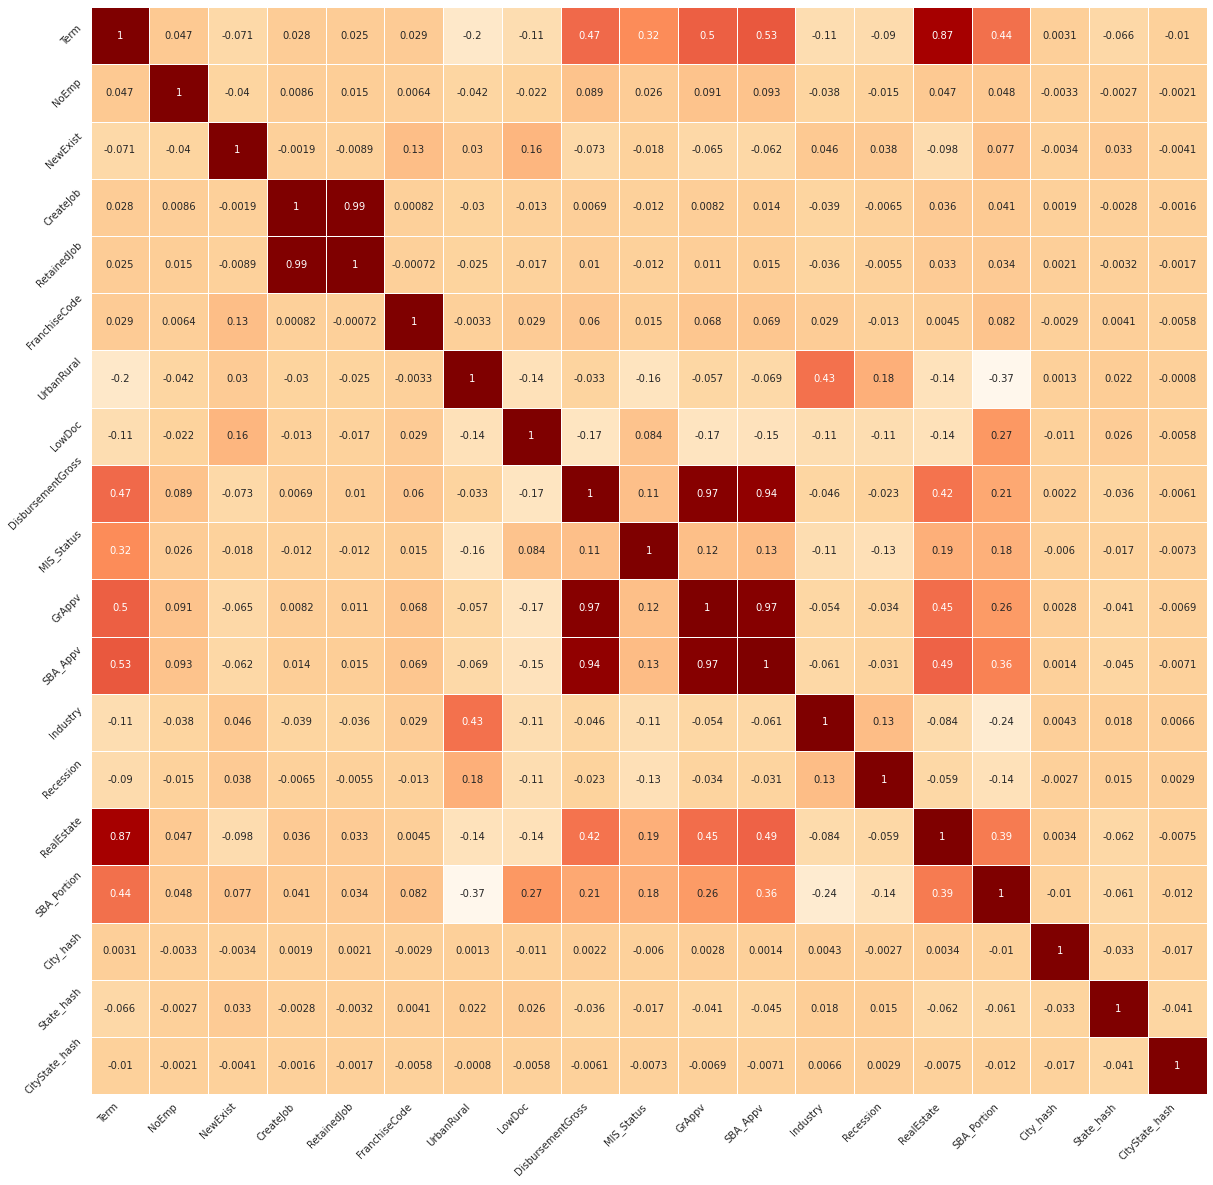

In [72]:
fig, ax = plt.subplots(figsize=(20,20))

g = sns.heatmap(
    sba.corr(),
    annot=True,
    ax=ax,
    cmap='OrRd',
    cbar=False,
    linewidth=1
)

g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_yticklabels(g.get_yticklabels(), rotation=45, horizontalalignment='right')

In [73]:
# Save 5
sba.to_csv(savepath + 'sba_save5.csv',index=False)
print('sba_save5.csv printed')

sba_save5.csv printed


<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>3. Build Model Using XGBoost</h2>
    </div>

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>3.1 Prepare Data</h2>
    </div>

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Metrics Function</b></div>

In [74]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix

def model_eval(y_valid,predictions):
    print('MAE:', metrics.mean_absolute_error(y_valid, predictions))
    print('MSE:', metrics.mean_squared_error(y_valid, predictions))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, predictions)))
    print()
    
    print("Classification Report:")
    print(classification_report(y_valid,predictions.round()))
    print()
    
    print("\033[1m" + "Accuracy for model:\033[0m %.2f" % (accuracy_score(y_valid, \
                                                            predictions.round()) * 100))

**Feature Importance**

In [75]:
from xgboost import plot_importance

# Plot feature importance
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize,dpi=600)
    return plot_importance(booster=booster, ax=ax)

**Mutual Information**

In [76]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    print()
    print("Please wait, Mutual Information gathering can take time (about 30 mins) ...")
    X = X.copy()
    #for colname in X.select_dtypes(["object", "category"]):
    #    X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    #discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    #mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = mutual_info_regression(X, y, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    print("Mutual Information gathering done ...")
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Process Class<b></div>

In [ ]:
!pip install imbalanced-learn

In [81]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

class process_model():
    
    x_over, y_over ='',''
    oversample_flag = False
    
    def __init__(self, X, y):
        self.X = X
        self.y = y

        print('MIS_Status Count : ',Counter(y))
        print()
    
    def osample(self):
        # define oversampling strategy
        oversample = RandomOverSampler(sampling_strategy='minority') 
    
        # fit and apply the transform
        process_model.X_over, process_model.y_over = oversample.fit_resample(self.X, self.y)

        # summarize class distribution
        print('Before Oversampling : ',Counter(self.y))
        print('After Oversampling  : ',Counter(process_model.y_over))
        
        # if data is oversampled, change this class variable to True
        process_model.oversample_flag = True
        
        return [process_model.X_over, process_model.y_over]
    
    # xgboost_improve - True if with tuning, False otherwise
    # desc - description of metrics report
    def prep_run_model(self, xgboost_improve, desc):
        self.xgboost_improve = xgboost_improve
        self.desc = desc
        
        if process_model.oversample_flag == True:
            self.X = process_model.X_over
            self.y = process_model.y_over
        
        
        # Split Data into Train:Validate:Test
        
        # Let's split the data in 80:10:10 for train:valid:test dataset
        # train_size=0.8 

        # In the first step we will split the data in training and remaining dataset
        X_train, X_rem, y_train, y_rem = train_test_split(self.X, self.y, train_size=0.8,\
                                                        random_state=101) 

        # Now since we want the valid and test size to be equal (10% each of overall data). 
        # we have to define valid_size=0.5 (that is 50% of remaining data)
        # test_size = 0.5

        X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem,test_size=0.5,\
                                                            random_state=101)
    
        print()
        print("\033[4m" + "Shapes Before And After Splitting Dataset :" + "\033[0m")
        print('X',X.shape,end=''), print('   y', y.shape)
        print('X_train',X_train.shape,end=''), print('   y_train', y_train.shape)
        print('X_valid',X_valid.shape,end=''), print('   y_valid', y_valid.shape)
        print('X_test', X_test.shape, end=''), print('   y_test', y_test.shape)
    
        print()
        print("Please wait, Fitting model can take time ...")
        if self.xgboost_improve == True:
            my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)
            my_model.fit(X_train, y_train, 
                     early_stopping_rounds=5, 
                     eval_set=[(X_valid, y_valid)], 
                     verbose=False)
        else:
            my_model = XGBRegressor()
            my_model.fit(X_train, y_train)
        print("Fitting model completed.")
    
        # Get predictions
        predictions = my_model.predict(X_valid)
    
    
        print()
        print("\033[4m" + self.desc + "\033[0m")
        model_eval(y_valid, predictions)
        
        return [y_valid,predictions,my_model, X_test, y_test]   # could use for metrics

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>3.1 Model 1</h2>
    </div>

In [78]:
# Select subset of predictors
X = sba.copy()

# Select target
y = X.pop('MIS_Status')

In [79]:
model1 = process_model(X, y)
model1_results2 = model1.prep_run_model(True, "Metrics")

MIS_Status Count :  Counter({1: 732244, 0: 155582})


Shapes Before And After Splitting Dataset :
X (887826, 18)   y (887826,)
X_train (710260, 18)   y_train (710260,)
X_valid (88783, 18)   y_valid (88783,)
X_test (88783, 18)   y_test (88783,)

Please wait, Fitting model can take time ...
Fitting model completed.

Metrics
MAE: 0.09997192224015151
MSE: 0.044257387538532866
RMSE: 0.21037439848644338

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83     15606
           1       0.96      0.97      0.96     73177

    accuracy                           0.94     88783
   macro avg       0.91      0.89      0.90     88783
weighted avg       0.94      0.94      0.94     88783


Accuracy for model: 94.17


<div style="font-family: Trebuchet MS;background-color:HoneyDew;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Accuracy for model is good; but ... Precision, Recall, and f1-score of classification 0 (CHGOFF) is much lower than that of 1 (P I F). This is because MIS_Status is heavily skewed towards 1 (P I F).  To solve this, we try Oversampling the data, in the next section.</b></div>

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>3.2 OverSample</h2>
    </div>

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;"><h2>3.2.1 Model 2</h2>
    </div>

In [ ]:
# Select subset of predictors
X = sba.copy()

# Select target
y = X.pop('MIS_Status')

In [82]:
model2 = process_model(X, y)
model2.osample()
model2_results = model2.prep_run_model(True, "Metrics")

MIS_Status Count :  Counter({1: 732244, 0: 155582})

Before Oversampling :  Counter({1: 732244, 0: 155582})
After Oversampling  :  Counter({1: 732244, 0: 732244})

Shapes Before And After Splitting Dataset :
X (887826, 18)   y (887826,)
X_train (1171590, 18)   y_train (1171590,)
X_valid (146449, 18)   y_valid (146449,)
X_test (146449, 18)   y_test (146449,)

Please wait, Fitting model can take time ...
Fitting model completed.

Metrics
MAE: 0.12835146546854903
MSE: 0.05512069306332251
RMSE: 0.23477796545528395

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     73456
           1       0.94      0.92      0.93     72993

    accuracy                           0.93    146449
   macro avg       0.93      0.93      0.93    146449
weighted avg       0.93      0.93      0.93    146449


Accuracy for model: 92.92


<div style="font-family: Trebuchet MS;background-color:HoneyDew;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>After oversampling of the minority class (CHGOFF), class 0 (CHGOFF) now has similar precision, recall, and f1-score as class 1 (P I F).
<br><br>     
The accuracy score is slightly lower than when not oversampled, but this should be more accurate in predicting the target. </b></div>

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

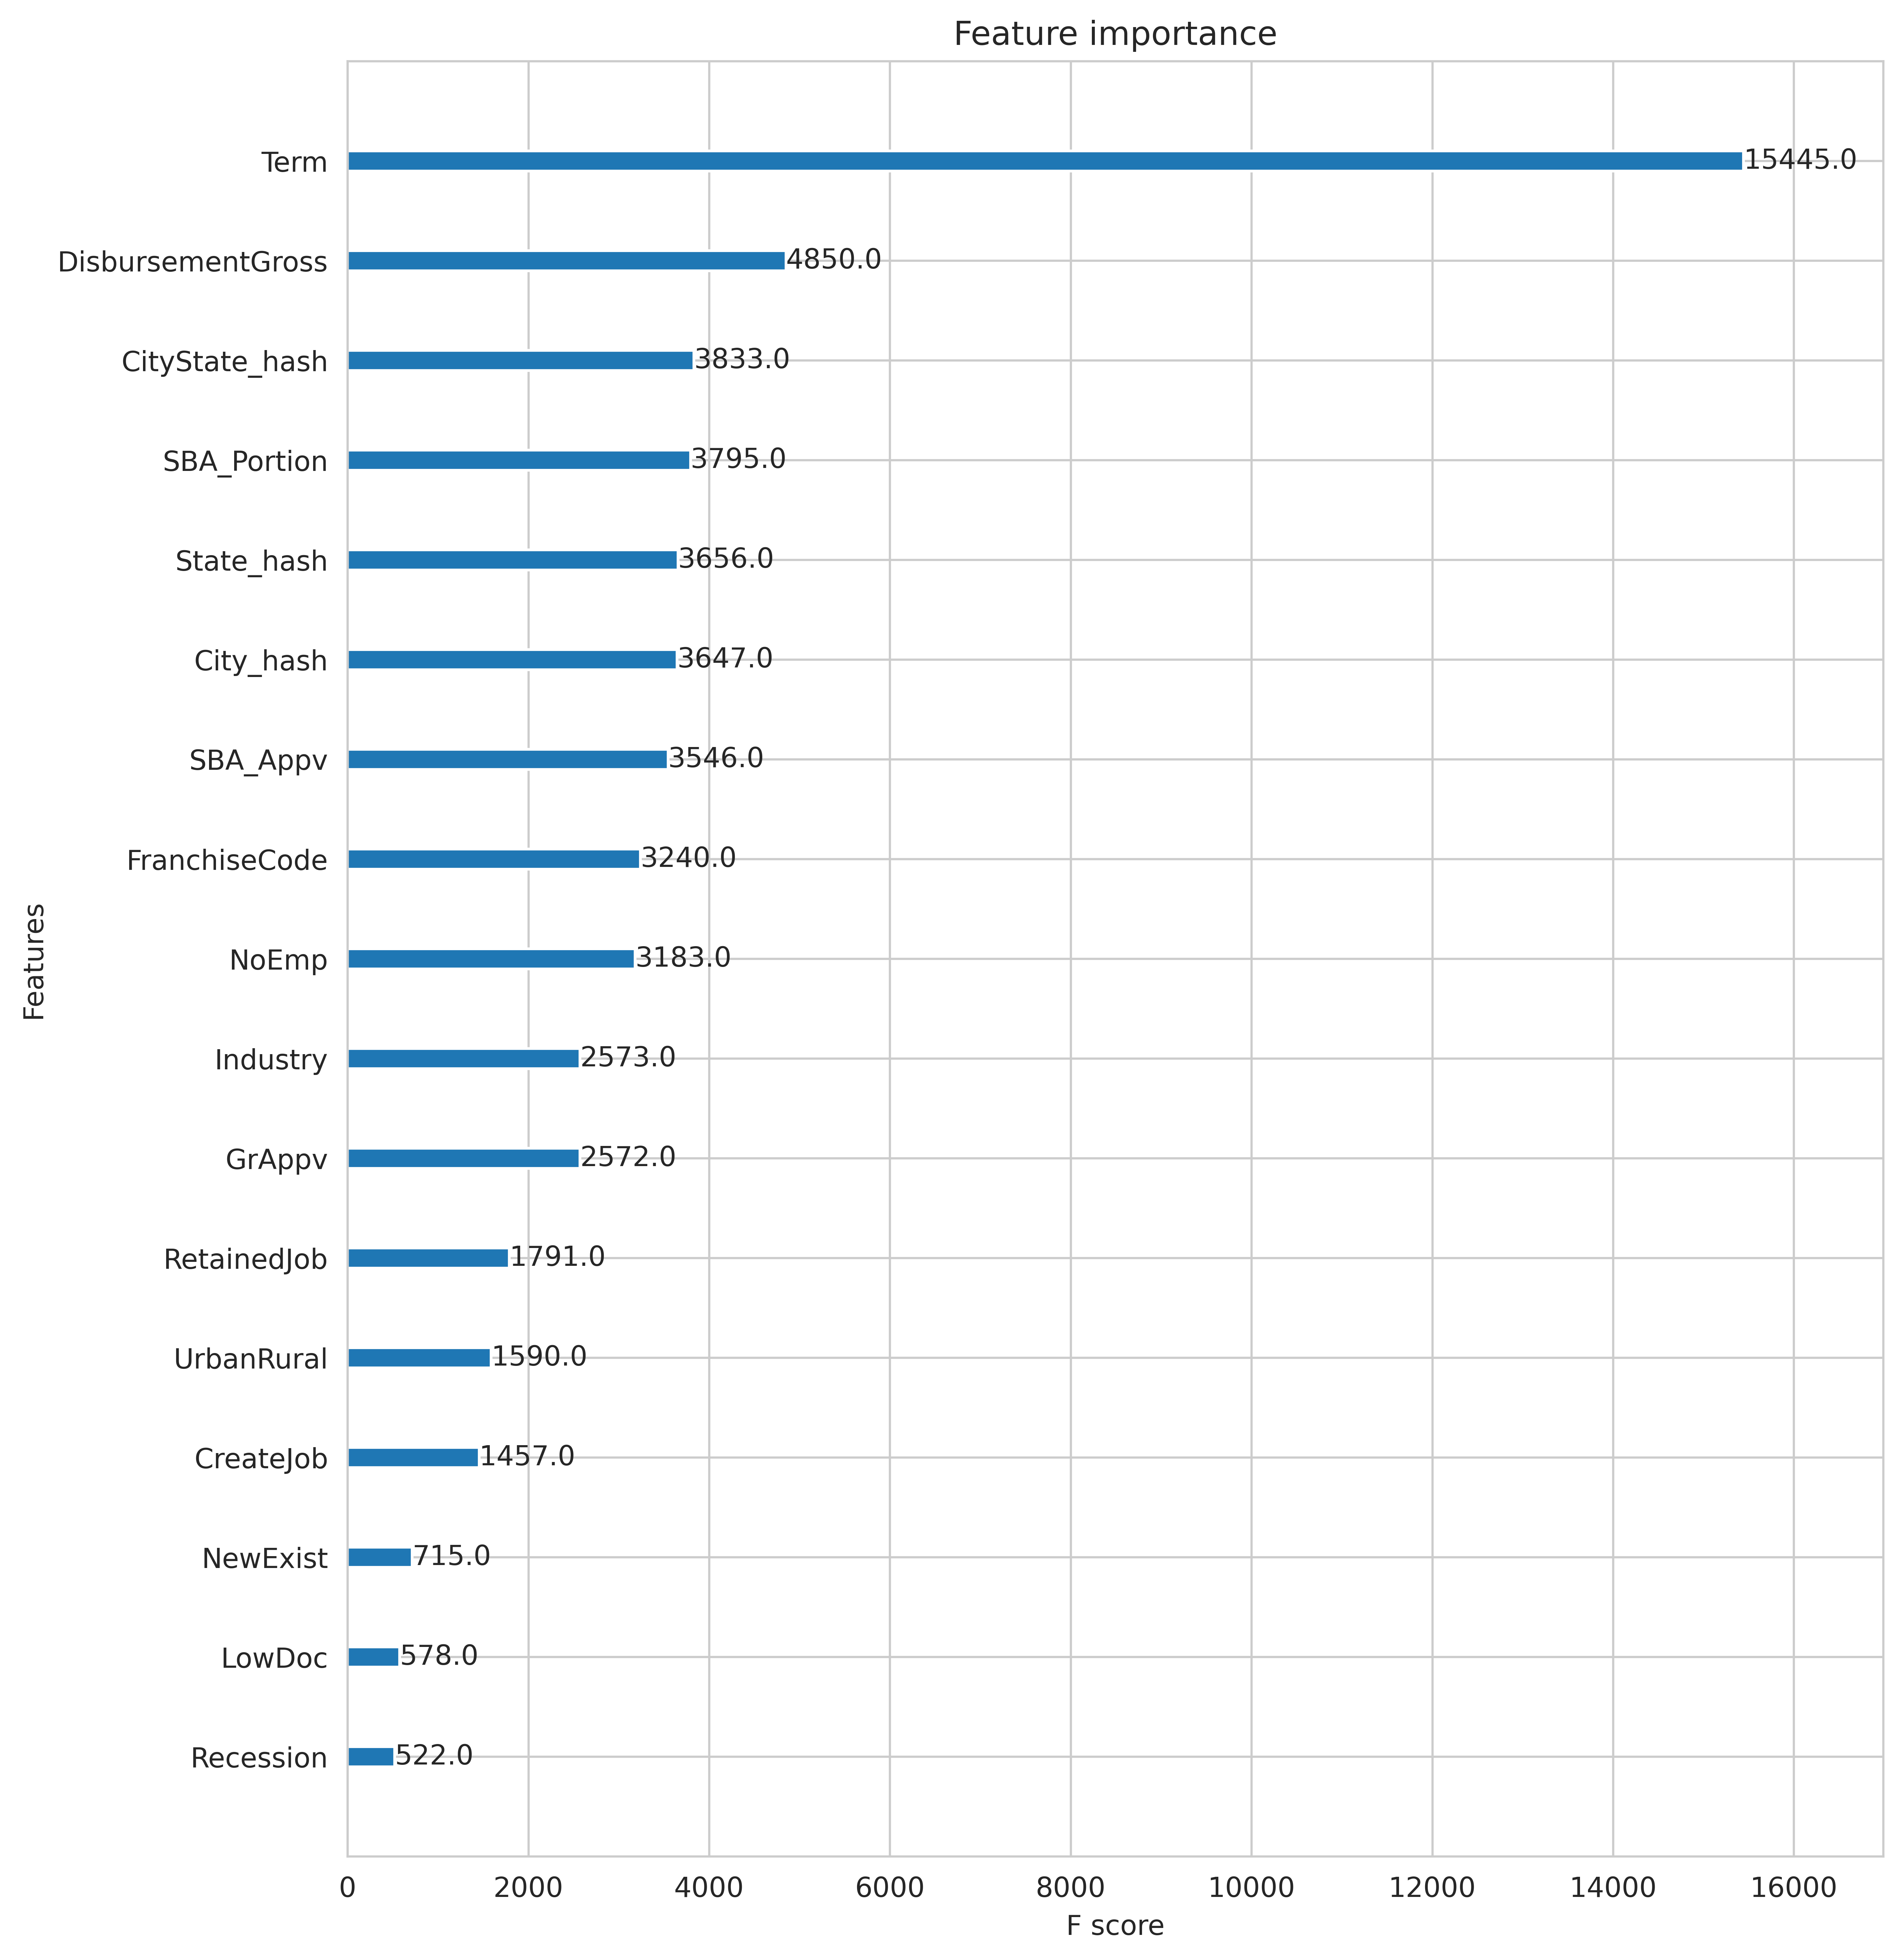

In [83]:
# Plot feature importance

plot_features(model2_results[2], (10,12))

<div style="font-family: Trebuchet MS;background-color:HoneyDew;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Observation</b><br>
    I was hoping to see <b>Industry</b> at a much higher position here, but apparently the incomplete data on industry had an effect.<br><br>
Furthermore, <b>Recession</b> has to be at a very high position, but is at the bottom instead.  This could be due to <b>Recession</b> data being highly skewed towards 1 (Not Recession).<br><br>
<b>Real Estate</b> should have good importance too.

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>3.2.2 Model 3</h2>
    <b>Build a Model Dataset Excluding Year 2011 and Above</b>

We restrict the time frame to loans by excluding those disbursed after 2010 due to the fact the term of a loan is frequently 5 or more years.
       </div>

In [84]:
sba_df = pd.read_csv(savepath + "sba_bef_2011.csv")
sba_df = sba_df.drop(columns = ['State', 'City','CityState',\
                                        'ChgOffPrinGr','DisbursementDate']) 
print(sba_df.columns)

# Select subset of predictors
X = sba_df.copy()

# Select target
y = X.pop('MIS_Status')

Index(['Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob',
       'FranchiseCode', 'UrbanRural', 'LowDoc', 'DisbursementGross',
       'MIS_Status', 'GrAppv', 'SBA_Appv', 'Industry', 'Recession',
       'RealEstate', 'SBA_Portion', 'City_hash', 'State_hash',
       'CityState_hash'],
      dtype='object')


In [85]:
model3 = process_model(X, y)
model3.osample()
model3_results = model3.prep_run_model(True, "Metrics")

MIS_Status Count :  Counter({1: 714212, 0: 154451})

Before Oversampling :  Counter({1: 714212, 0: 154451})
After Oversampling  :  Counter({1: 714212, 0: 714212})

Shapes Before And After Splitting Dataset :
X (868663, 18)   y (868663,)
X_train (1142739, 18)   y_train (1142739,)
X_valid (142842, 18)   y_valid (142842,)
X_test (142843, 18)   y_test (142843,)

Please wait, Fitting model can take time ...
Fitting model completed.

Metrics
MAE: 0.12524180563652068
MSE: 0.05318084132980524
RMSE: 0.2306097164687673

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     71391
           1       0.94      0.92      0.93     71451

    accuracy                           0.93    142842
   macro avg       0.93      0.93      0.93    142842
weighted avg       0.93      0.93      0.93    142842


Accuracy for model: 93.20


<div style="font-family: Trebuchet MS;background-color:HoneyDew;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>We get a slightly better score.  Will use this dataset as the last dataset, for now.</b></div>

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

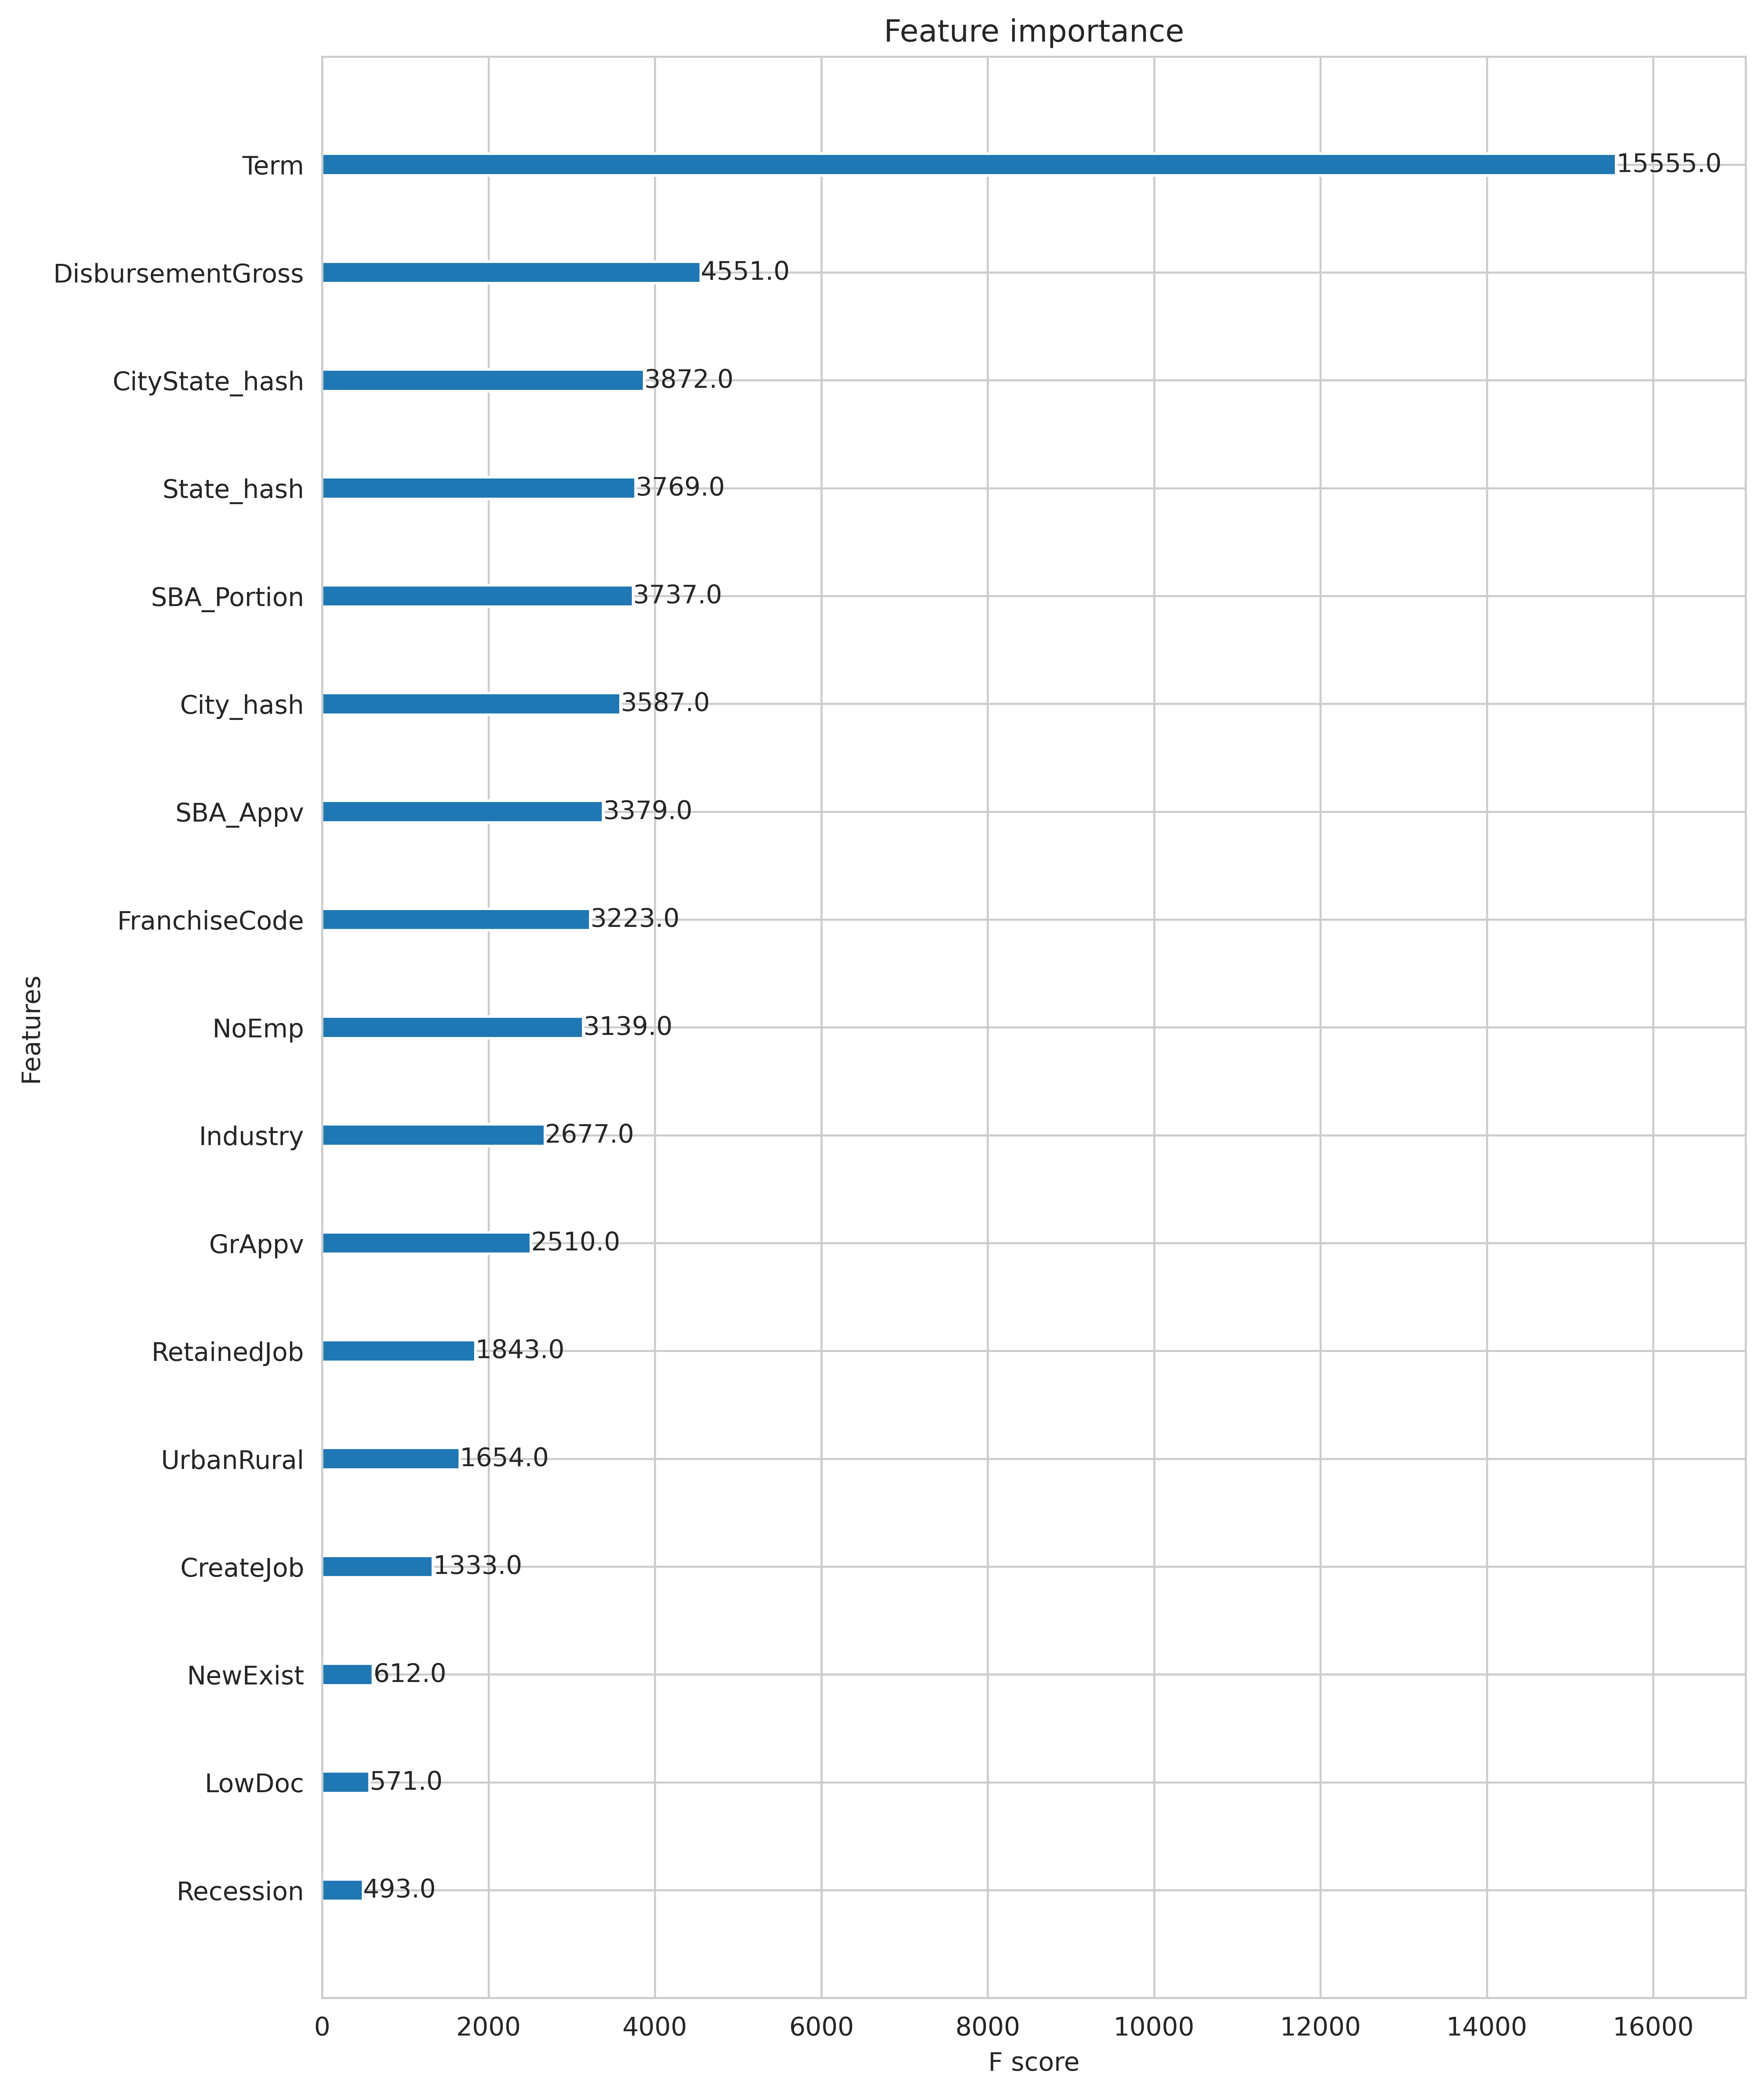

In [86]:
# Plot feature importance
my_model3 = model3_results[2]
plot_features(my_model3, (10,14))

In [87]:
# Save 6
sba_df.to_csv(savepath + 'sba_save6.csv',index=False)

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 20px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>4. Test Model</h2>
    </div>
    

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 20px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>4.1 Test Model with Test Dataset</h2>
    Test Dataset was previously unseen by the model.
    </div>

In [88]:
X_test = model3_results[3]
y_test = model3_results[4]

In [89]:
# Get predictions
predictions6 = my_model3.predict(X_test)
model_eval(y_test, predictions6)

MAE: 0.12644619258009646
MSE: 0.05423793082187449
RMSE: 0.23289038370416776

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     71280
           1       0.94      0.92      0.93     71563

    accuracy                           0.93    142843
   macro avg       0.93      0.93      0.93    142843
weighted avg       0.93      0.93      0.93    142843


Accuracy for model: 93.06


<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 20px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>4.2 Test Model with User Input</h2>
    </div>

<div style="font-family: Trebuchet MS;background-color:HoneyDew;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;"><b>So let's assume the following are the entries of a user, through a user interface, looking for a prediction from our model.</b></div>

In [90]:
'''
17 Entries :
'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob',
       'FranchiseCode', 'UrbanRural', 'LowDoc', 'DisbursementGross',
       GrAppv', 'SBA_Appv', 'Industry', 'Recession','RealEstate', 'SBA_Portion', 'City', 'State'
'''

user_input = [2,0,1,0,0,1,0,0,50000,50000,25000,71,0,0,50,'EVANSVILLE','IN']

city = user_input[15]
state = user_input[16]
city_state = city + "_" + state

city_hash = int(hashlib.sha1(('City' + "_" + \
                              str(city)).encode('utf-8')).hexdigest(), 16) % 900000
state_hash = int(hashlib.sha1(('State' + "_" + \
                              str(state)).encode('utf-8')).hexdigest(), 16) % 900000
city_state_hash = int(hashlib.sha1(('CityState' + "_" + \
                              str(city_state)).encode('utf-8')).hexdigest(), 16) % 900000

print(city_hash)
print(state_hash)
print(city_state_hash)

user_input[15] = city_hash
user_input[16] = state_hash
user_input.append(city_state_hash)

print(user_input)

444879
705173
717067
[2, 0, 1, 0, 0, 1, 0, 0, 50000, 50000, 25000, 71, 0, 0, 50, 444879, 705173, 717067]


In [91]:
features = np.array([user_input])   

# using inputs to predict the output
pred = my_model3.predict(features)
print("Prediction: {}".format(pred))

Prediction: [0.03278296]


**Predictions:**<br>
- near 1 -> can approve
- lower than 0.5 -> do not approve

Of course, in real life, will need to check further using other data or models if available.

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 20px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>5. Mutual Information Scores</h2>
 A general-purpose metric, normally used before selecting and building a model, but used here in the end, for comparison.
    </div>

In [92]:
sba_df = pd.read_csv(savepath + "sba_save6.csv")
print(sba_df.columns)

# Select subset of predictors
X = sba_df.copy()

# Select target
y = X.pop('MIS_Status')

Index(['Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob',
       'FranchiseCode', 'UrbanRural', 'LowDoc', 'DisbursementGross',
       'MIS_Status', 'GrAppv', 'SBA_Appv', 'Industry', 'Recession',
       'RealEstate', 'SBA_Portion', 'City_hash', 'State_hash',
       'CityState_hash'],
      dtype='object')


In [93]:
# a long time to run
model3_mi = process_model(X, y)
osample_xy = model3_mi.osample()
mi_scores = make_mi_scores(osample_xy[0], osample_xy[1])

MIS_Status Count :  Counter({1: 714212, 0: 154451})

Before Oversampling :  Counter({1: 714212, 0: 154451})
After Oversampling  :  Counter({1: 714212, 0: 714212})

Please wait, Mutual Information gathering can take time (about 30 mins) ...
Mutual Information gathering done ...


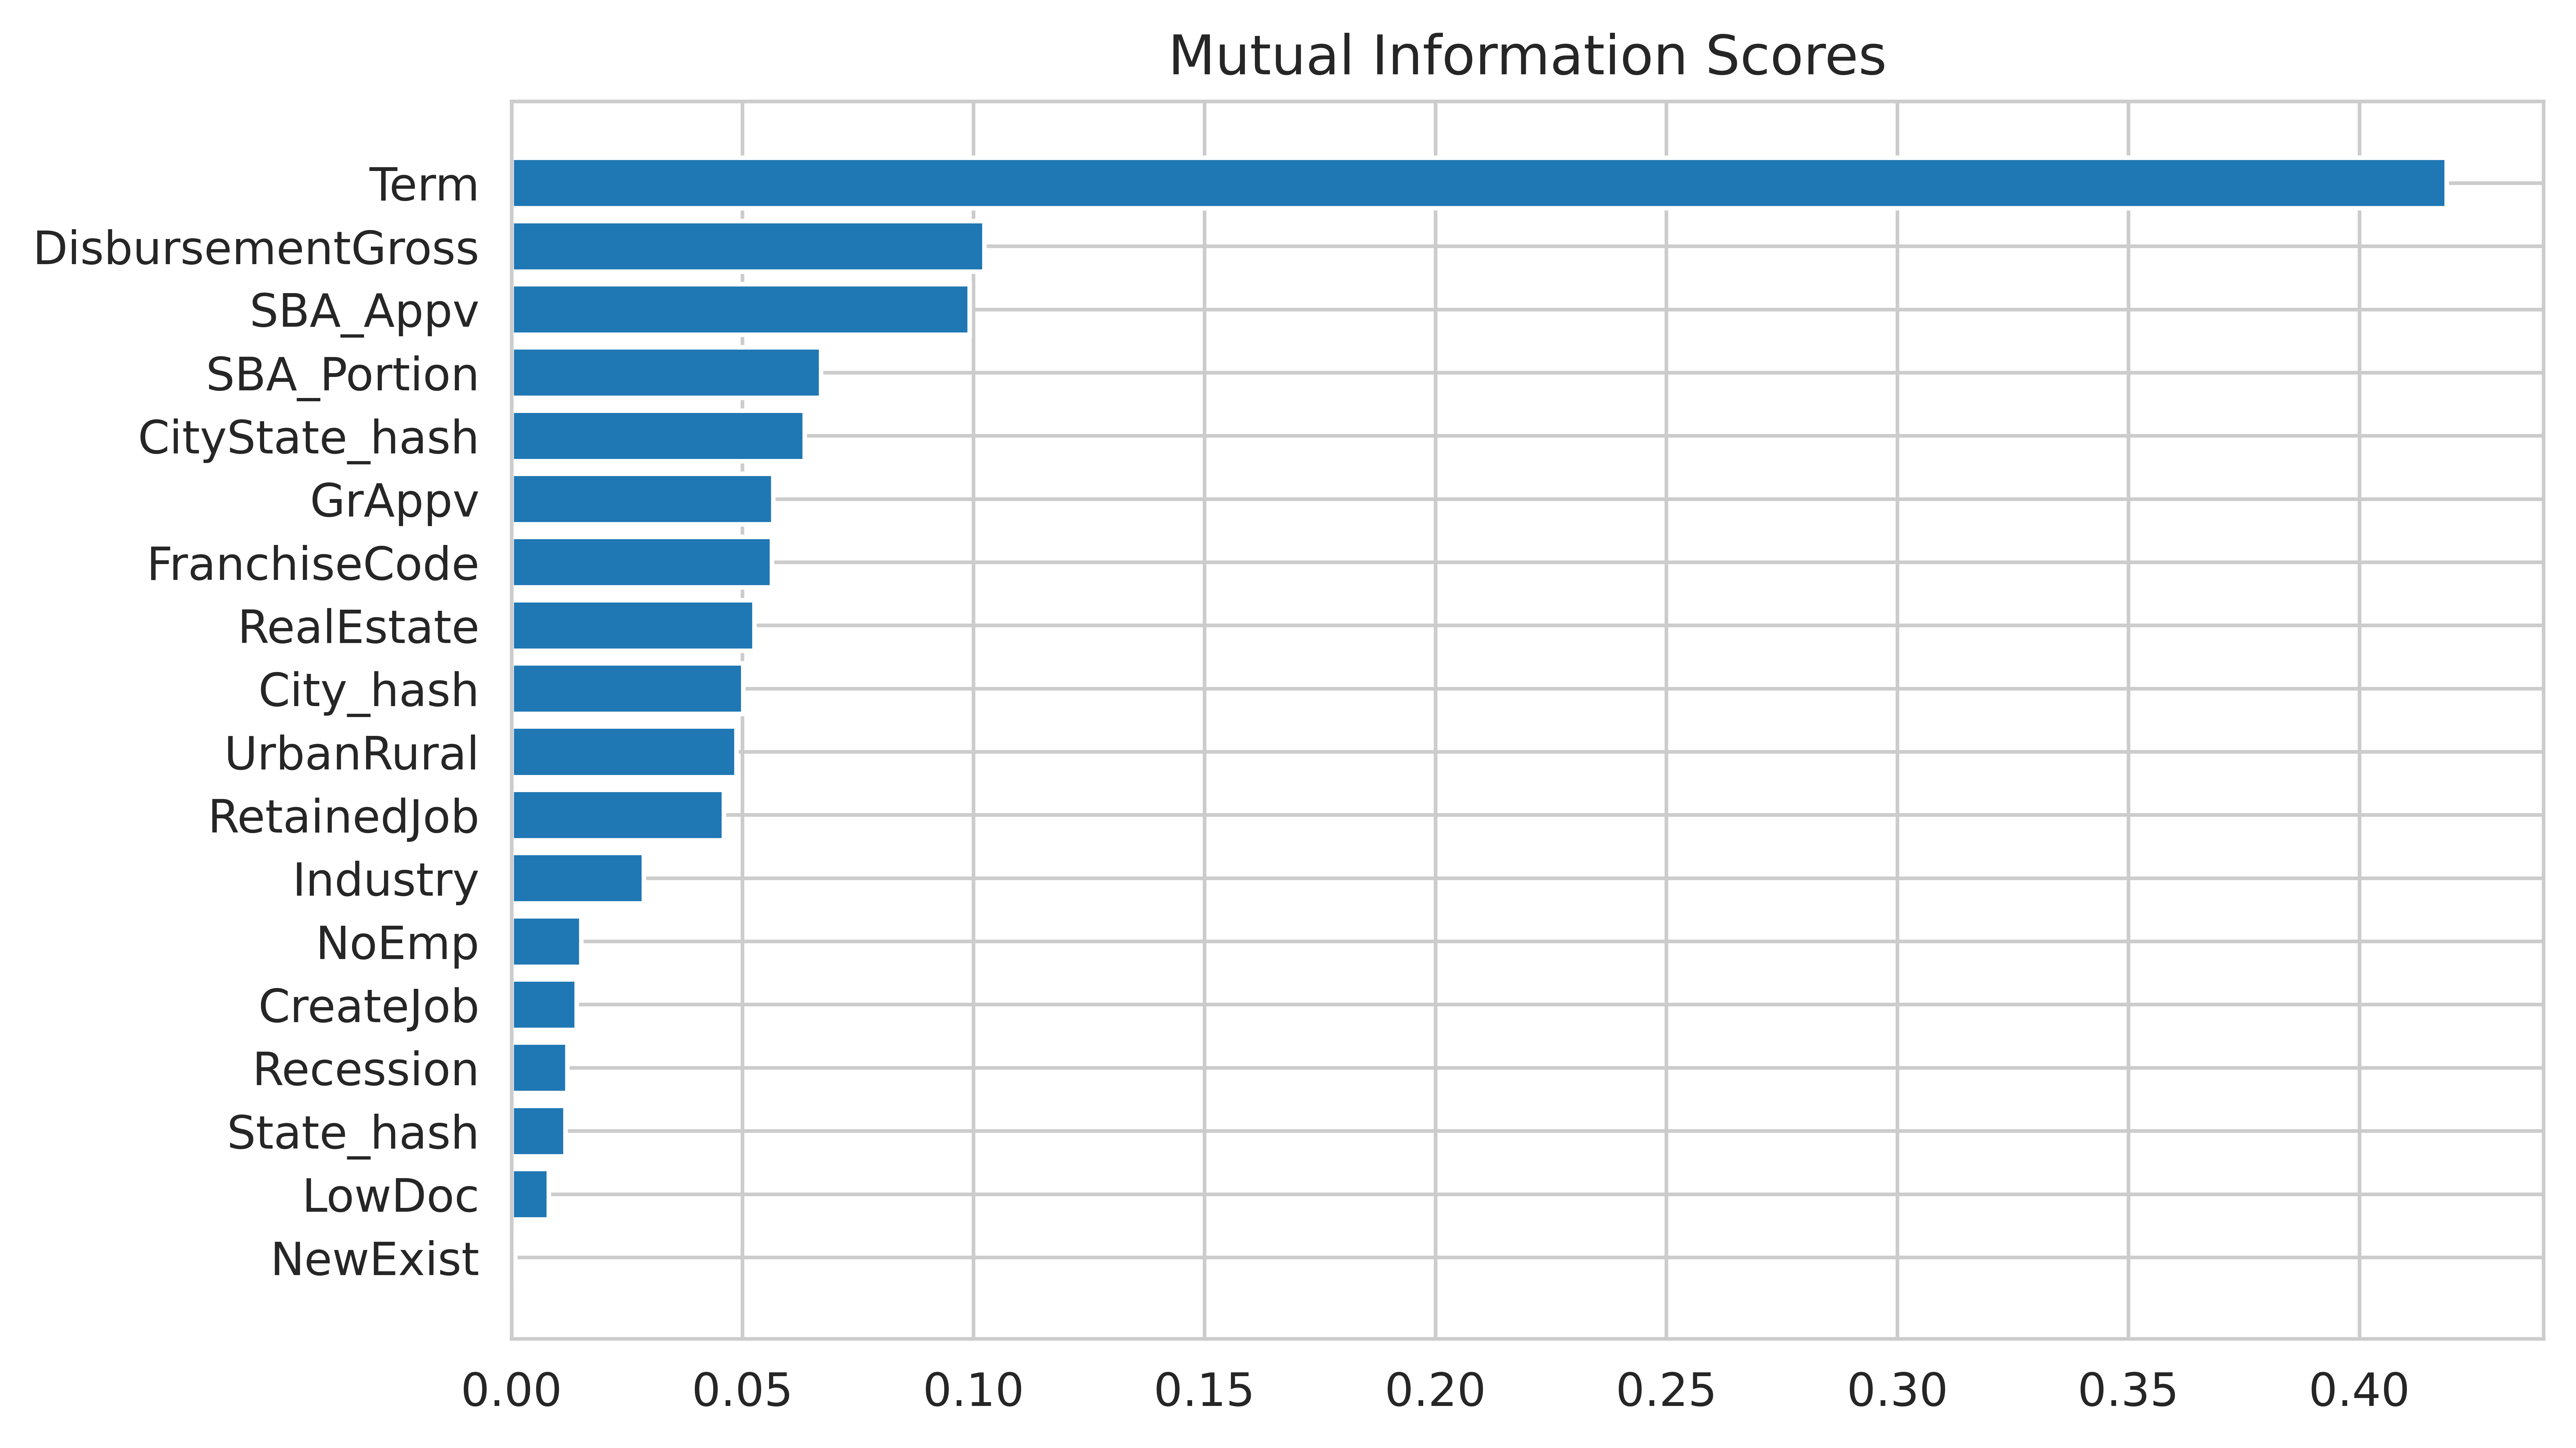

In [94]:
plt.figure(dpi=1200, figsize=(8, 5))
plot_mi_scores(mi_scores)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

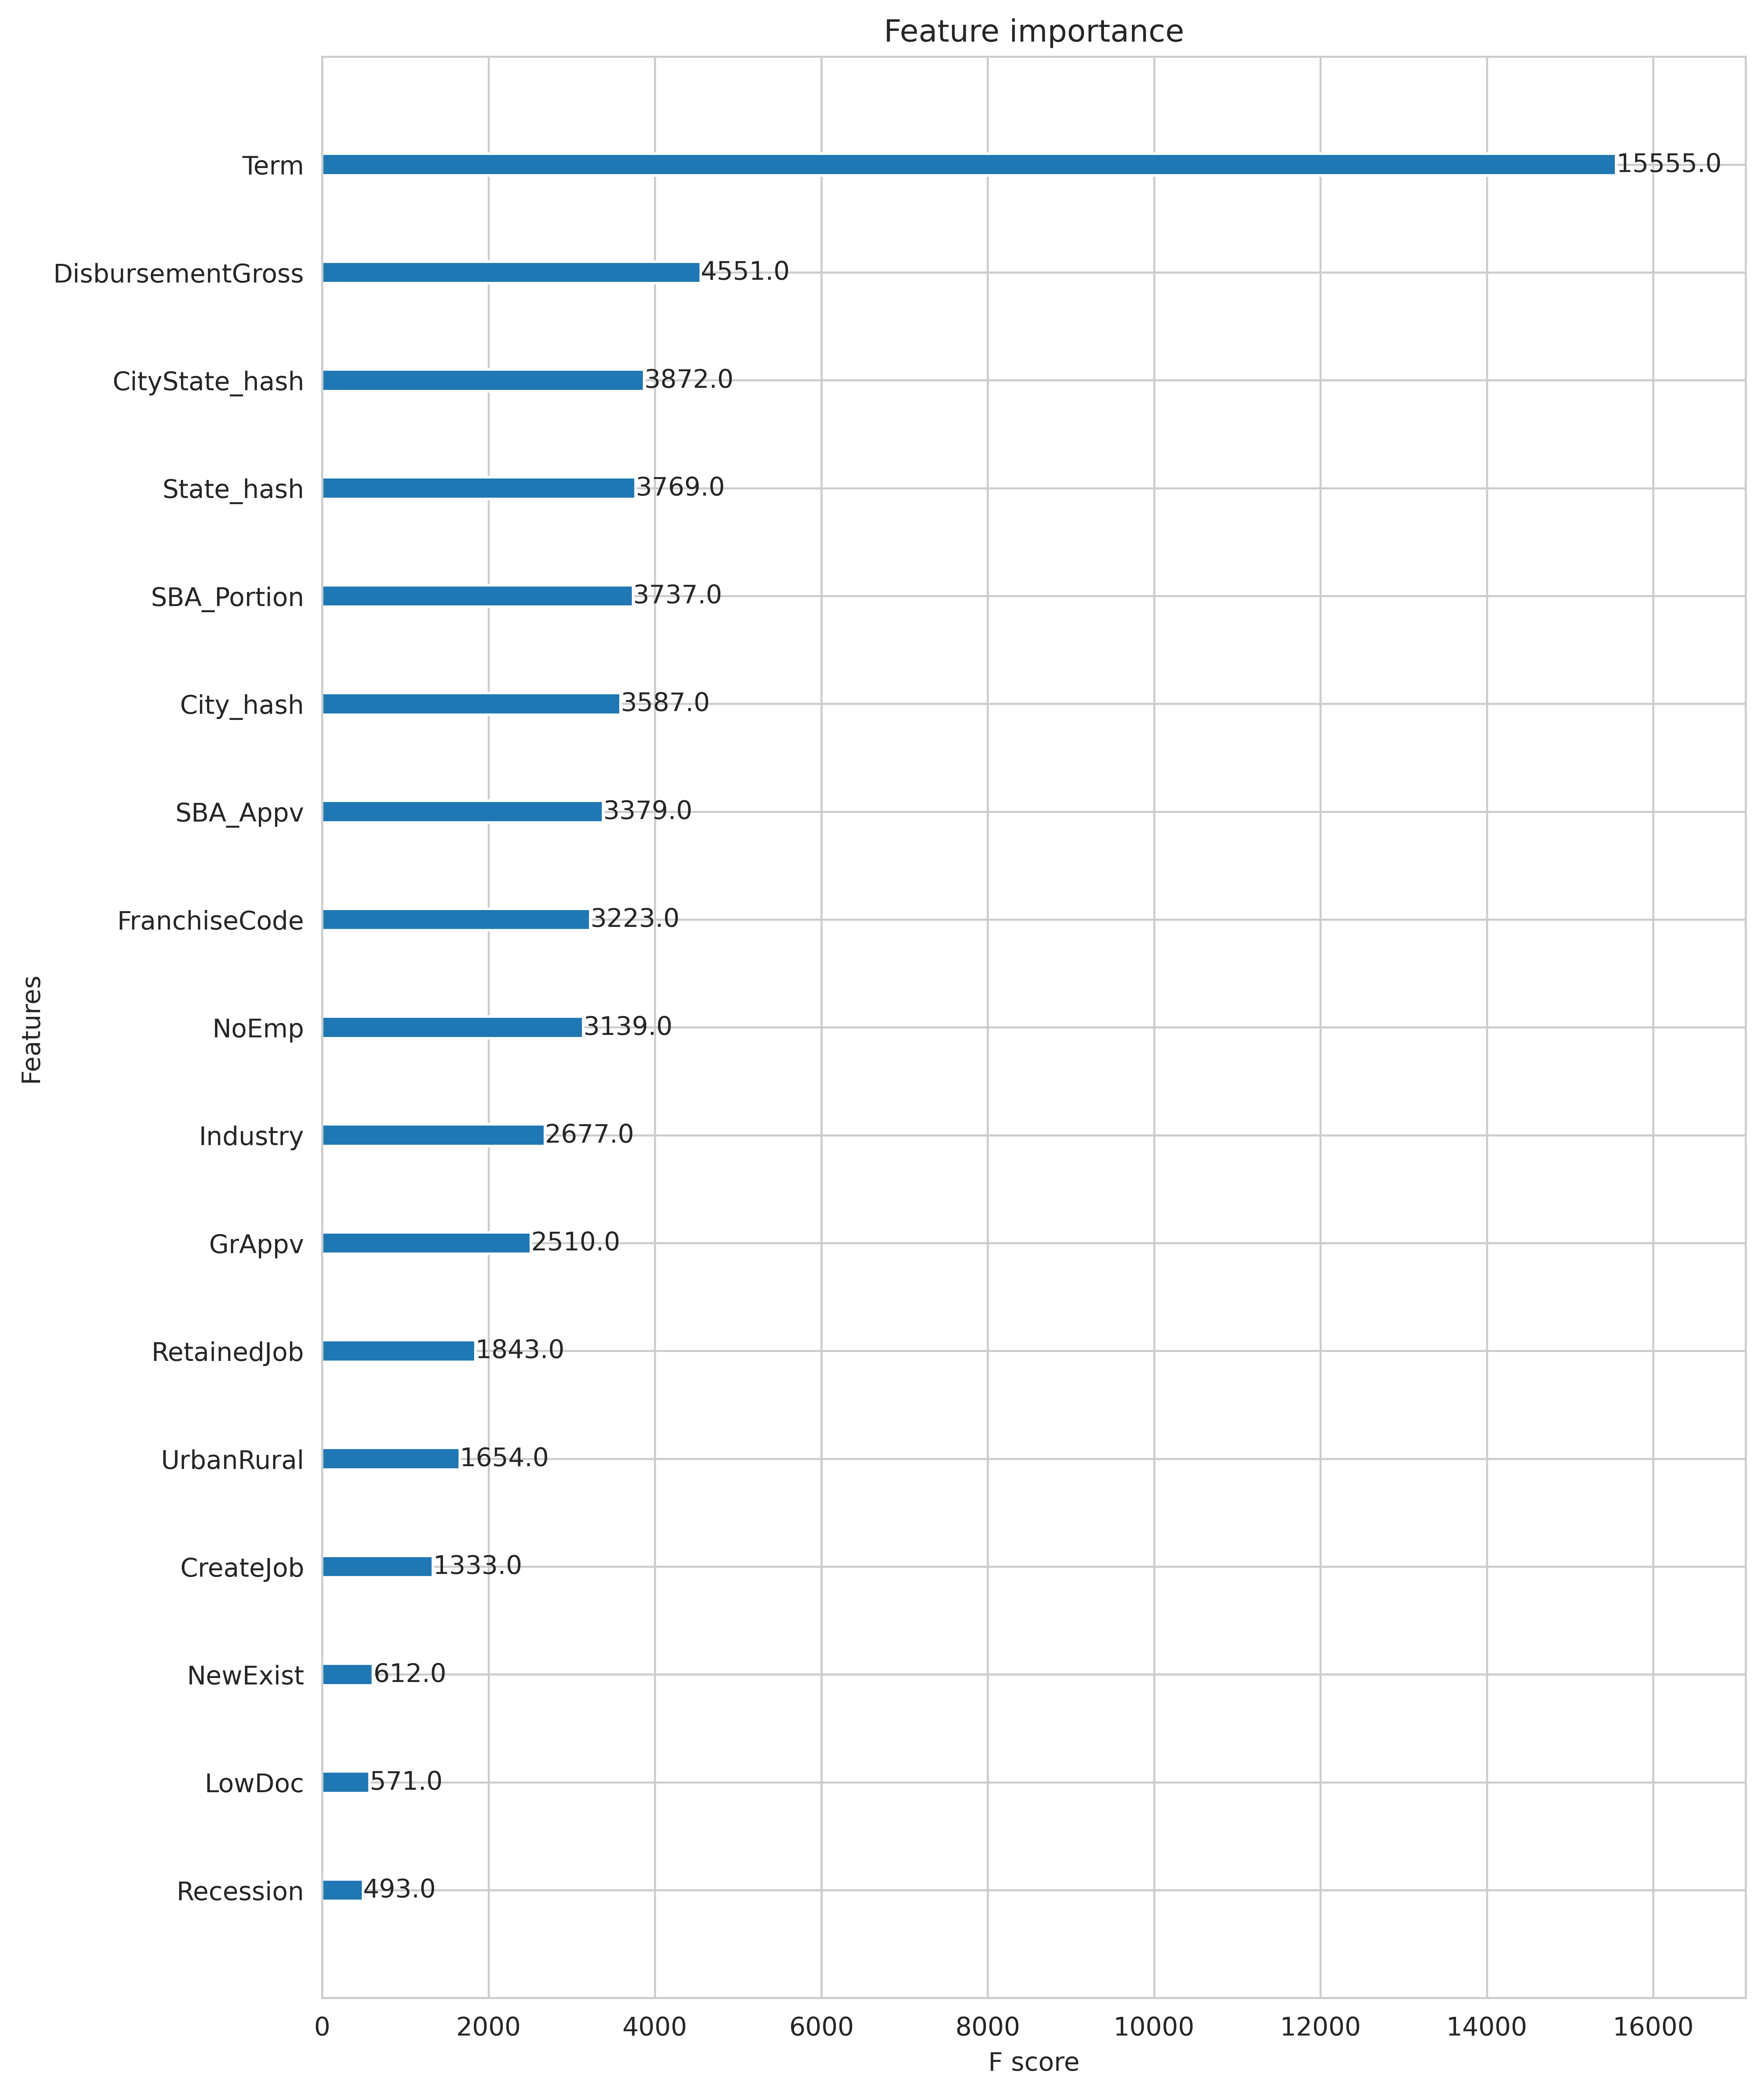

In [96]:
# Plot feature importance
my_model3 = model3_results[2]
plot_features(my_model3, (10,14))

<div style="font-family: Trebuchet MS;background-color:HoneyDew;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">The importance ranked by <b>Mutual Information</b> and <b>XGBoost Feature Importance</b> metrics are different.  Which ranking do you think is more reasonable ?</div>

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 20px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>6. Trim Dataset</h2>
After the preprocessing and encoding steps, we had a total of <b>18 features</b> and not all of these may be useful in forecasting the loan default. Alternatively we can select the <b>top 5 or top 8 features</b>, based on the feature importance plot above, which had a major contribution in forecasting loan defaults.<br><br>

If the model performance is similar in both the cases, that is – by using 18 features and by using 5-8 features, then we should use only the top 8 features, in order to keep the model simpler and more efficient.

The idea is to have a less complex model without compromising on the overall model performance.
</div>

In [100]:
#Let's retain the top 8 from Mutual Information metric
Xmi = X[['Term', 'DisbursementGross', 'SBA_Appv', 'SBA_Portion', 'CityState_hash', \
         'GrAppv', 'FranchiseCode', 'RealEstate']]

#Let's retain the top 8 from Feature Importance metric
Xfi = X[['Term', 'DisbursementGross', 'CityState_hash',
              'State_hash', 'SBA_Portion', 'City_hash', 'SBA_Appv', 'FranchiseCode']] 

In [101]:
model3_mi = process_model(Xmi, y)
model3_mi.osample()
model3_mi_results = model3_mi.prep_run_model(True, "Mutual Information Metrics")

MIS_Status Count :  Counter({1: 714212, 0: 154451})

Before Oversampling :  Counter({1: 714212, 0: 154451})
After Oversampling  :  Counter({1: 714212, 0: 714212})

Shapes Before And After Splitting Dataset :
X (868663, 18)   y (868663,)
X_train (1142739, 8)   y_train (1142739,)
X_valid (142842, 8)   y_valid (142842,)
X_test (142843, 8)   y_test (142843,)

Please wait, Fitting model can take time ...
Fitting model completed.

Mutual Information Metrics
MAE: 0.1310871180470649
MSE: 0.05937962198185211
RMSE: 0.2436793425423093

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     71391
           1       0.93      0.91      0.92     71451

    accuracy                           0.92    142842
   macro avg       0.92      0.92      0.92    142842
weighted avg       0.92      0.92      0.92    142842


Accuracy for model: 92.14


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

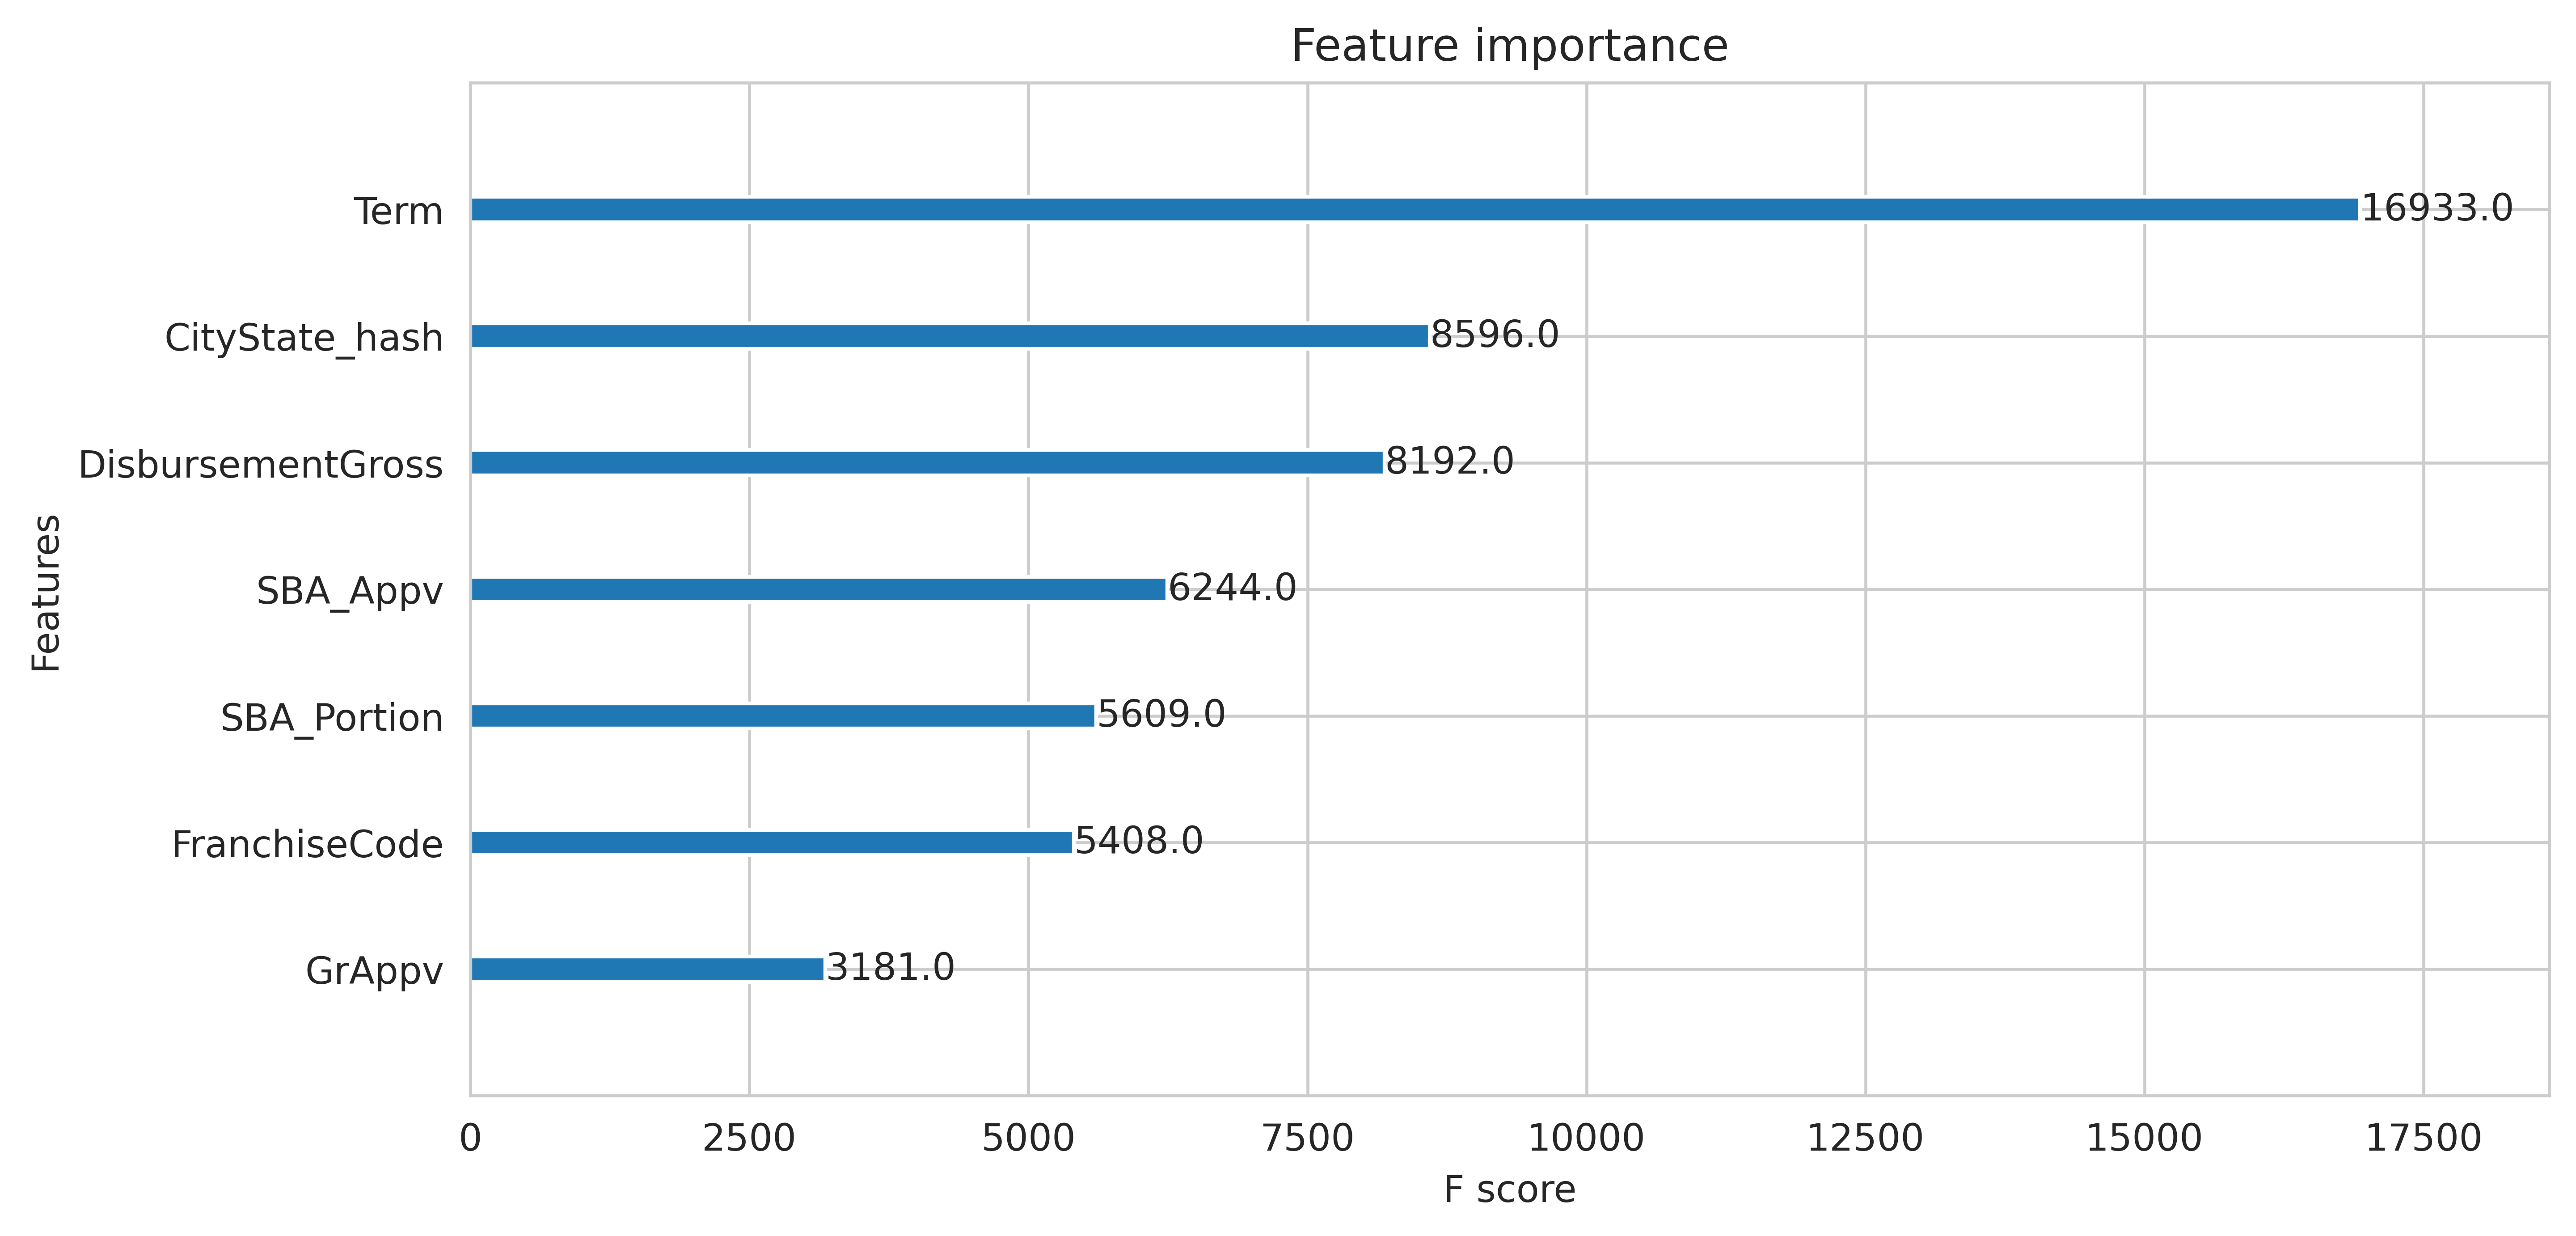

In [106]:
# Plot feature importance
my_model_mi = model3_mi_results[2]
plot_features(my_model_mi, (10,5))

In [110]:
# Test with Unseen test data

X_test = model3_results[3]
X_test_mi = X_test[['Term', 'DisbursementGross', 'SBA_Appv', 'SBA_Portion', 'CityState_hash', \
             'GrAppv', 'FranchiseCode', 'RealEstate']]

y_test = model3_results[4]

predictions_mi = my_model_mi.predict(X_test_mi)
model_eval(y_test, predictions_mi)

MAE: 0.13136449785929383
MSE: 0.06000021080539101
RMSE: 0.24494940458264236

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     71280
           1       0.93      0.91      0.92     71563

    accuracy                           0.92    142843
   macro avg       0.92      0.92      0.92    142843
weighted avg       0.92      0.92      0.92    142843


Accuracy for model: 92.09


In [103]:
model3_fi = process_model(Xfi, y)
model3_fi.osample()
model3_fi_results = model3_fi.prep_run_model(True, "Feature Importance Metrics")

MIS_Status Count :  Counter({1: 714212, 0: 154451})

Before Oversampling :  Counter({1: 714212, 0: 154451})
After Oversampling  :  Counter({1: 714212, 0: 714212})

Shapes Before And After Splitting Dataset :
X (868663, 18)   y (868663,)
X_train (1142739, 8)   y_train (1142739,)
X_valid (142842, 8)   y_valid (142842,)
X_test (142843, 8)   y_test (142843,)

Please wait, Fitting model can take time ...
Fitting model completed.

Feature Importance Metrics
MAE: 0.1317419009746877
MSE: 0.05821120946690311
RMSE: 0.241269992885363

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     71391
           1       0.93      0.91      0.92     71451

    accuracy                           0.92    142842
   macro avg       0.92      0.92      0.92    142842
weighted avg       0.92      0.92      0.92    142842


Accuracy for model: 92.38


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

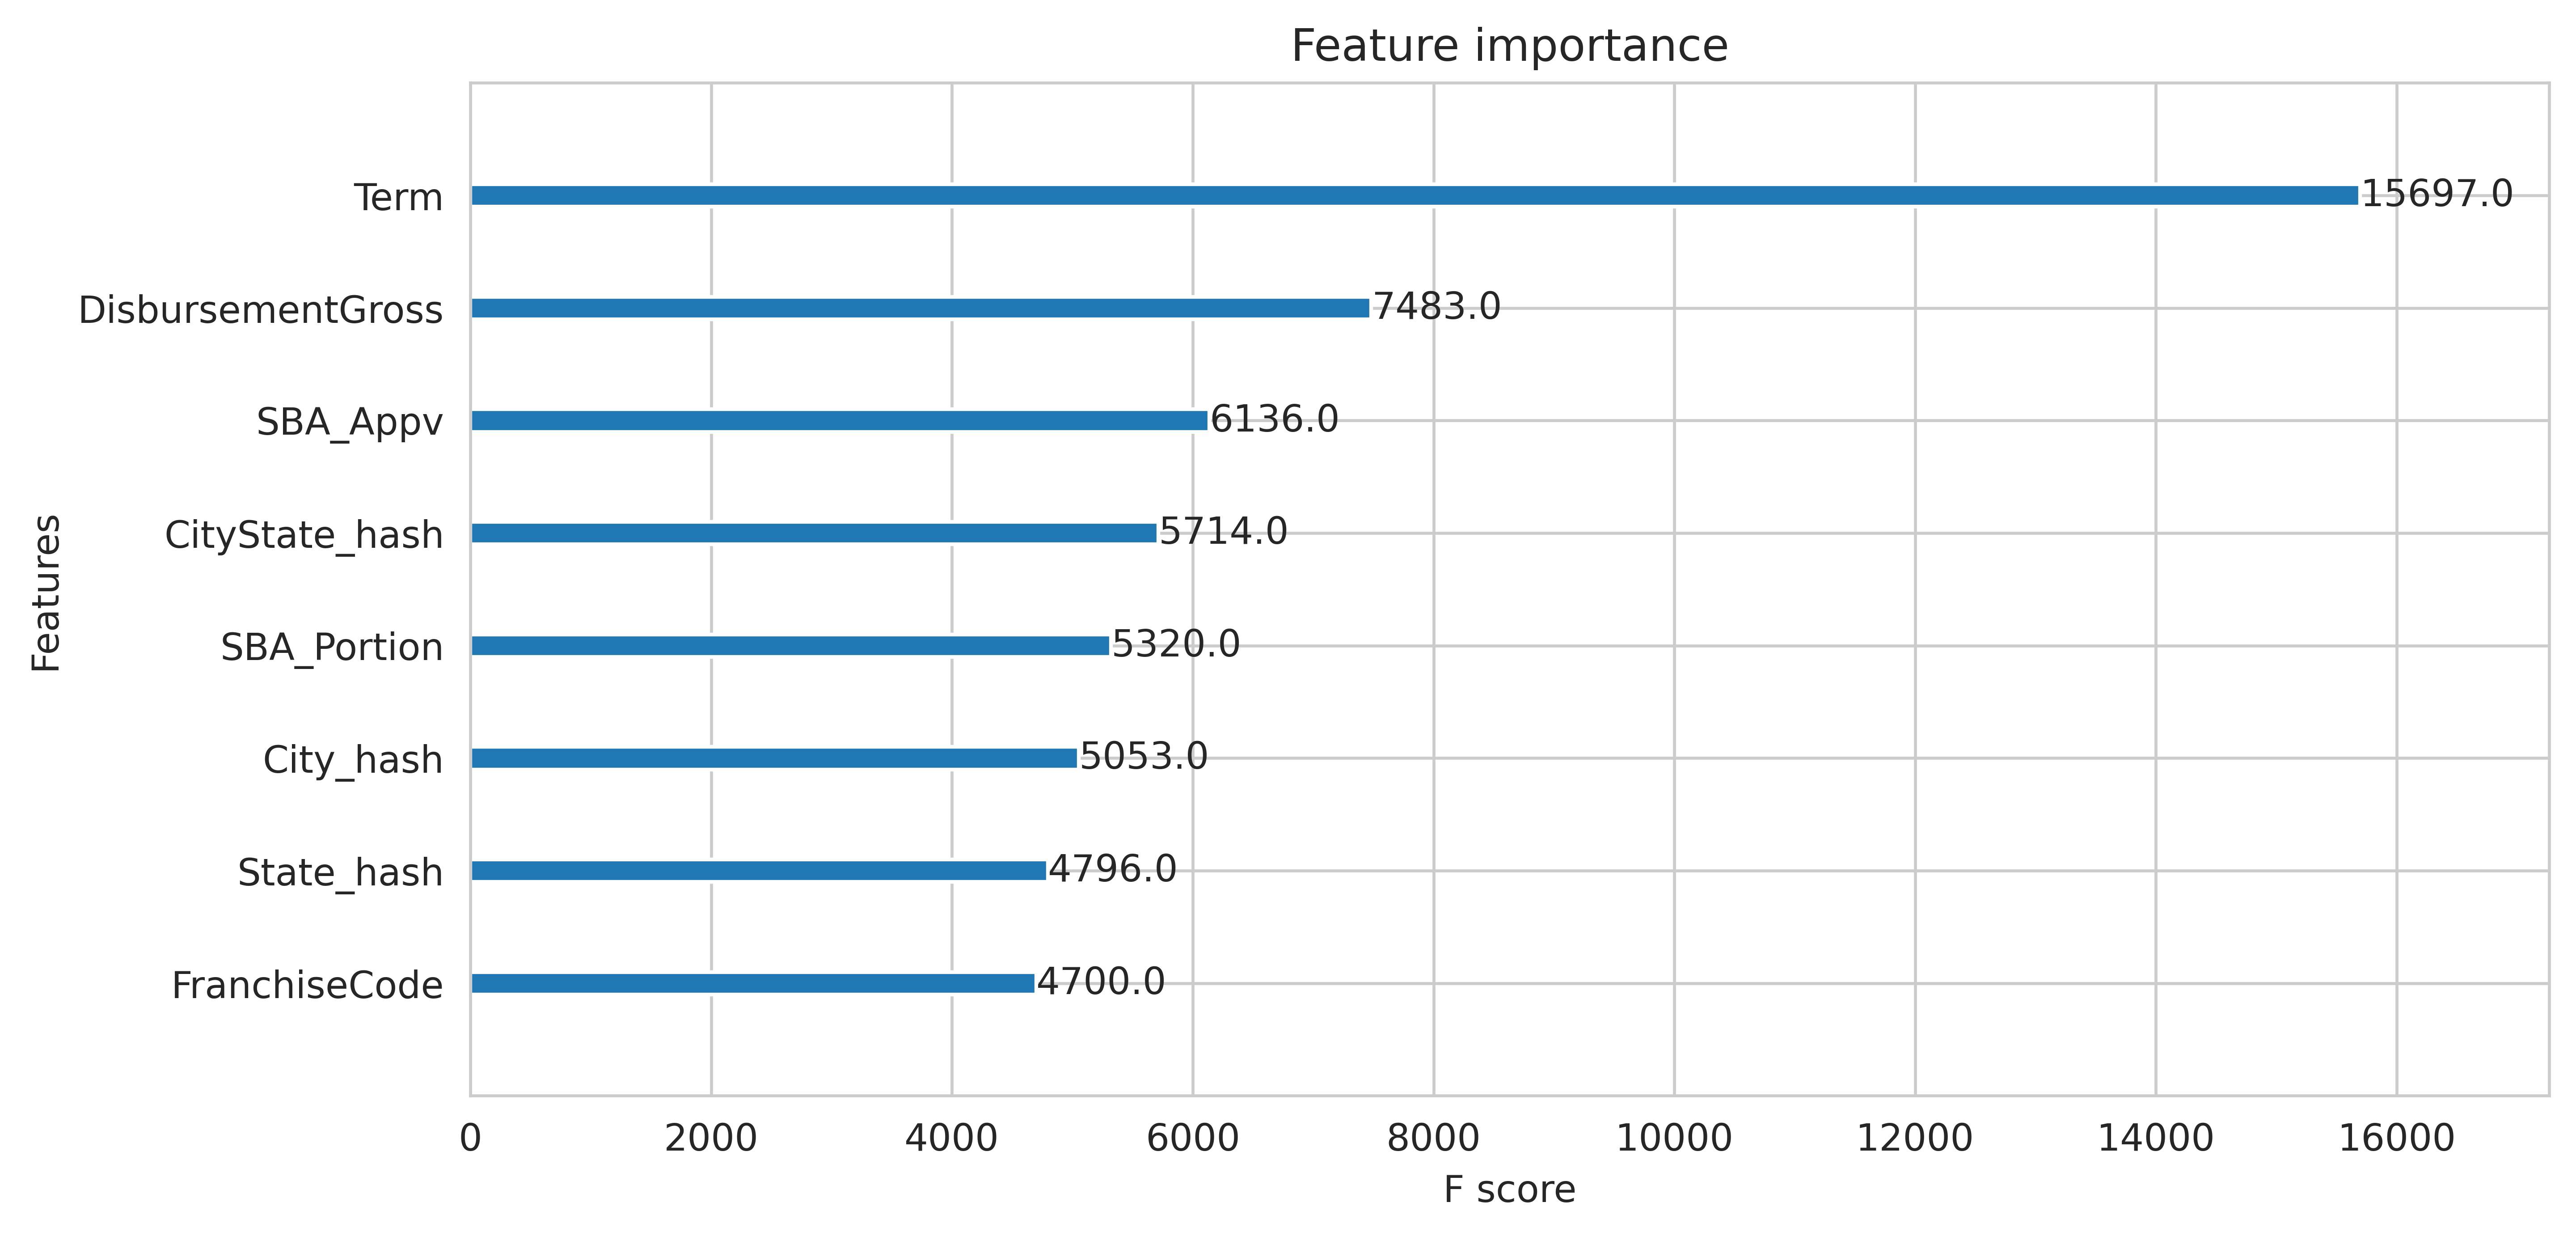

In [107]:
# Plot feature importance
my_model_fi = model3_fi_results[2]
plot_features(my_model_fi, (10,5))

In [112]:
# Test with Unseen test data

X_test = model3_results[3]
X_test_fi = X_test[['Term', 'DisbursementGross', 'CityState_hash',
              'State_hash', 'SBA_Portion', 'City_hash', 'SBA_Appv', 'FranchiseCode']]

y_test = model3_results[4]

predictions_fi = my_model_fi.predict(X_test_fi)
model_eval(y_test, predictions_fi)

MAE: 0.13229687300645265
MSE: 0.05881563446871018
RMSE: 0.24251934864812372

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92     71280
           1       0.93      0.91      0.92     71563

    accuracy                           0.92    142843
   macro avg       0.92      0.92      0.92    142843
weighted avg       0.92      0.92      0.92    142843


Accuracy for model: 92.30


<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 20px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>7. Results</h2>
</div>

**Do we select the full dataset, or the trimmed dataset ?**<br><br>
Model 3  - RMSE: 0.23289038370416776  /   Accuracy for model: 93.20

Model MI - RMSE: 0.2436793425423093   /   Accuracy for model: 92.14

Model FI - RMSE: 0.241269992885363    /   Accuracy for model: 92.38<br><br>

Approx 1 point accuracy difference between trimmed and full.  